In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
from lmfit.models import GaussianModel

In [2]:
from astropy.timeseries import LombScargle as lst

In [3]:
#somewhat arbitrarily used a few plotting colors
#set them to variables here so they can be easily changed
c1 = 'cornflowerblue'
c2 = 'navy'
c3 = 'rebeccapurple'
c4 = '#CF6275'
c5 = 'maroon'

In [4]:
def ps(name):
    '''save as postscript file'''
    plt.savefig(name+'.ps')
def png(name,dpi=200):
    '''save as png with sufficient quality'''
    plt.savefig(name+'.png',dpi=dpi,bbox_inches='tight')

# 1. Load in Data and Plot I Band Lightcurve

In [5]:
pwd

'/Users/lenatreiber/Desktop/Yale/OGLEPeriods'

In [6]:
#load Ogle IV, only keep first three columns
og4 = np.loadtxt('phot.dat',usecols=range(0,3))
#turn into panda dataframe with labelled columns based on known time units (Julian Date)
og4 = pd.DataFrame(og4,columns=['JD','I mag','I mag err'])
#add columns for MJD and MJD-50000, which will be the time unit used in all plots
og4['MJD'] = og4['JD']-2400000.5
og4['MJD-50000'] = og4['MJD']-50000
og4['I mag'] = og4['I mag']+.041 #calibrating
#deleting duplicates (points with same time)
og4 = og4.drop_duplicates(subset=['MJD'], keep='last')

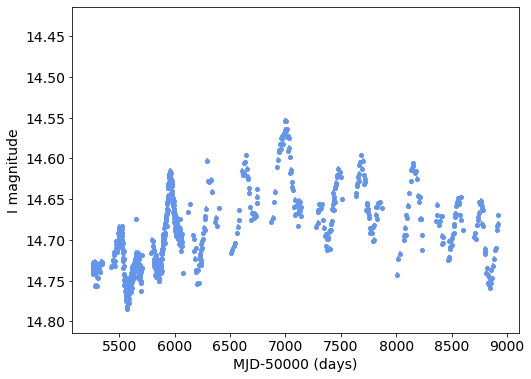

In [7]:
#Ogle IV
plt.figure(figsize=(8,6))
plt.errorbar(og4['MJD']-50000,og4['I mag'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
#flipped y axis since showing magnitudes
plt.ylim(14.8+.014,14.4+.014)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
plt.tick_params(labelsize=14)
#plt.savefig('Imag.ps') #testing saving plot as ps

# 2. Detrend Data and Perform LS Periodogram

In [8]:
#detrending by Georgios

# Detrend with window size, window size refers to number of points,
# so 100  points its about 100-200 days (OGLE takes 1 observation every 1-3 days)
# a more efficient way to detrend perhaps is to remove the average of each year, be carefull when detrending... 
# if you detrend using a window of 30 days .. and then you find a period of 30 days... 
# then you introduced an artificial signal.

Imag=og4['I mag']
window=201 #also tested other windows to make sure periodogram results unaffected
print('Smooth (window = ', window, ') and detrend data...')
Ismooth = signal.savgol_filter(Imag, window, 1)
Imean = np.mean(Imag)
print('Average I band magnitude', Imean)
og4['I detrend 2'] = Imag-Ismooth  + og4['I mag'].mean()

print('min:',og4['I detrend 2'].min(),'max:',og4['I detrend 2'].max())

# # clip large deviations
# mask = (Idetrend > -0.03) & (Idetrend < 0.03)
# Idetrend = Idetrend+Imean
# time = time[mask]
# Idetrend = Idetrend[mask]
# eIdetrend = Imag_err[mask]
# print 'No of selected data points:', len(time)


Smooth (window =  201 ) and detrend data...
Average I band magnitude 14.69307702182286
min: 14.590290952171113 max: 14.785156623812906


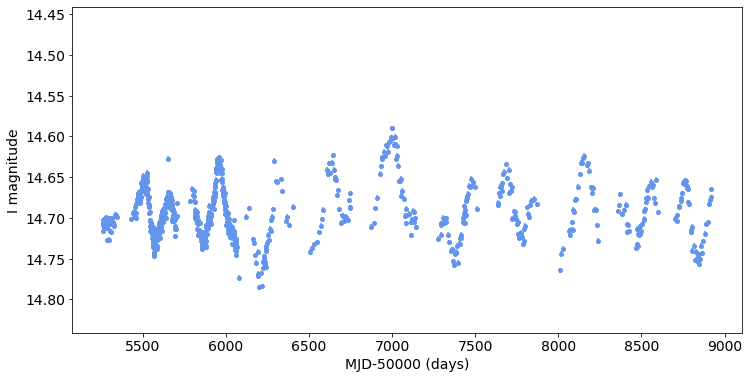

In [9]:
#detrended lightcurve
plt.figure(figsize=(12,6))
plt.errorbar(og4['MJD-50000'],og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
#flipped y axis since showing magnitudes
plt.ylim(14.8+.041,14.4+.041)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
plt.tick_params(labelsize=14)

In [10]:
#find link for credit
def periodogram(more=False,minf=.005,maxf=.05,t=og4['MJD-50000'],y=og4['I detrend 2'],dy=og4['I mag err'],bayes=False,sub=False):
    '''Perform and plot single LS periodogram.
    Two different return options.'''
    fig = plt.figure(figsize=(8, 4))

    ls = LombScargle(t, y)
    freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=minf,
                           maximum_frequency=maxf,
                           samples_per_peak=10)
    if bayes: power = np.exp(power)
    plt.plot(1/freq,power,color='black')
    best_freq = freq[np.argmax(power)]
    plt.xlabel('Period',fontsize=14)
    plt.ylabel('Power',fontsize=14)
    if more:
        return freq, power, 1/best_freq
    else:
        return 1/best_freq

In [323]:
def pdsub(st,end,minf=.005,maxf=.05,t=og4['MJD-50000'],y=og4['I detrend 2'],dy=og4['I mag err'],c=[],sub=False,line=False,figsize=(20,5)):
    '''Subplots of periodograms based on lists of indices of data.'''
    fig,ax = plt.subplots(1,len(st),figsize=figsize)
    best_pds = []
    for s in range(len(st)):
        ls = LombScargle(t[st[s]:end[s]], y[st[s]:end[s]])
        freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=minf,
                           maximum_frequency=maxf,
                           samples_per_peak=50) #originally 10
        ax[s].plot(1/freq,power,color='black')
        best_freq = freq[np.argmax(power)]
        if line: ax[s].axvline(1/best_freq,color=c[s])
        best_pds.append(1/best_freq)
        ax[s].tick_params(labelsize=14)
    ax[0].set_xlabel('Period (days)',fontsize=18)
    ax[0].set_ylabel('Power',fontsize=18)
    plt.subplots_adjust(wspace=.12)    
    return best_pds

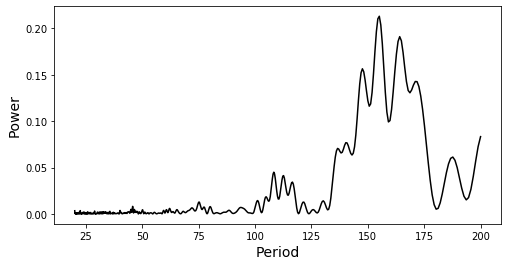

In [12]:
freq, power, best_p = periodogram(minf=.005,more=True)
#png('presgram')

In [13]:
pdframe = pd.DataFrame(columns=['freq','power','period'])
pdframe['freq'] = freq
pdframe['power'] = power
pdframe['period'] = 1./freq

In [14]:
pdframe = pdframe.sort_values(by='power',ascending=False)
pdframe[:5] #164 also high-powered

freq     power      period
53  0.006448  0.212960  155.093654
54  0.006475  0.210207  154.439379
52  0.006420  0.203575  155.753495
55  0.006502  0.196313  153.790602
40  0.006093  0.190985  164.133090

In [15]:
best_p

155.09365367860207

248.81855254052064

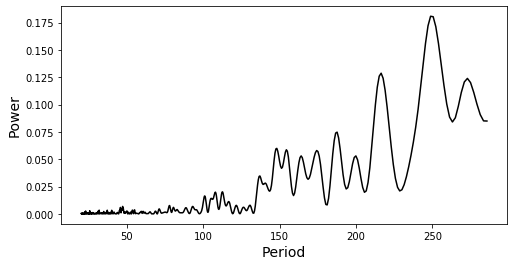

In [16]:
#periodogram with all data without detrending
periodogram(y=og4['I mag'],minf=.0035)

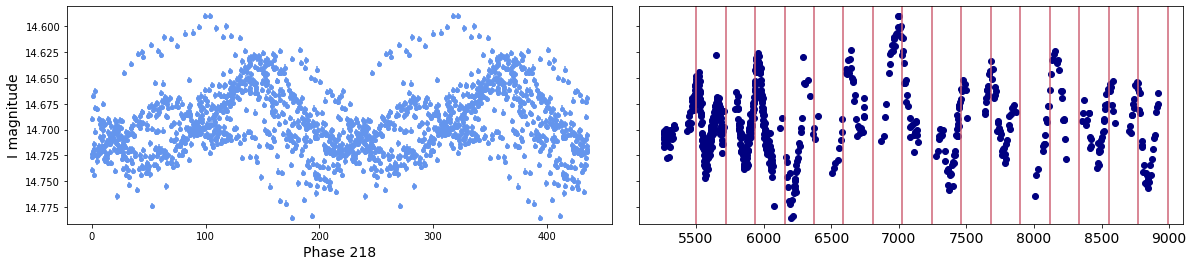

In [17]:
#showing that 218 days is not a meaningful signal, at least for us
fig,ax=plt.subplots(1,2,figsize=(20,4),sharey=True)
ax[0].errorbar(og4['MJD']%218,og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
ax[0].errorbar(218+og4['MJD']%218,og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)

#flipped y axis since showing magnitudes
ax[0].set_ylim(14.75+.041,14.54+.041)
ax[0].set_xlabel('Phase 218',fontsize=14)
ax[0].set_ylabel('I magnitude',fontsize=14)

ax[1].scatter(og4['MJD-50000'],og4['I detrend 2'],color='navy')
for i in range(17):
    plt.axvline(5501+218*i,color=c4)
plt.tick_params(labelsize=14)
plt.subplots_adjust(wspace=.05)

In [18]:
#without duplicates, best period is 155 days in detrended data
og4['phase 155'] = og4['MJD-50000'] % best_p

Text(0, 0.5, 'I magnitude')

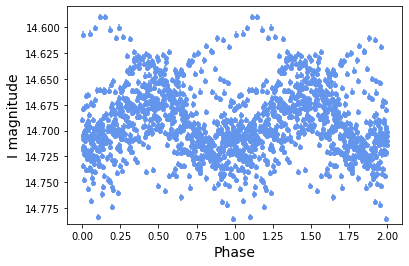

In [19]:
#version up to phase two
#remember data collection densest for first few flares, where this period is actually correct
plt.figure(figsize=(6,4))
plt.errorbar(og4['phase 155']/best_p,og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
plt.errorbar(1+og4['phase 155']/best_p,og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
plt.ylim(14.75+.04,14.54+.04)
#flipped y axis since showing magnitudes
plt.xlabel('Phase',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
#plt.tick_params(labelsize=14)

Text(0, 0.5, 'I magnitude')

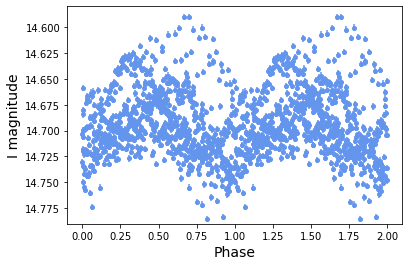

In [20]:
#testing 164 days as well
og4['phase 164'] = og4['MJD-50000'] % 164
plt.figure(figsize=(6,4))
plt.errorbar(og4['phase 164']/164,og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
plt.errorbar(1+og4['phase 164']/164,og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
plt.ylim(14.75+.04,14.54+.04)
#flipped y axis since showing magnitudes
plt.xlabel('Phase',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
#plt.tick_params(labelsize=14)

## 3.  Test Periods of 155 Days and 164 Days
starting from peak of whole lightcurve (peak of flare around 7000)

In [21]:
np.argmin(og4['I mag'])

556

In [22]:
maxt = np.float(og4['MJD-50000'][556:557])
maxt

6997.281070000026

Text(0, 0.5, 'I magnitude')

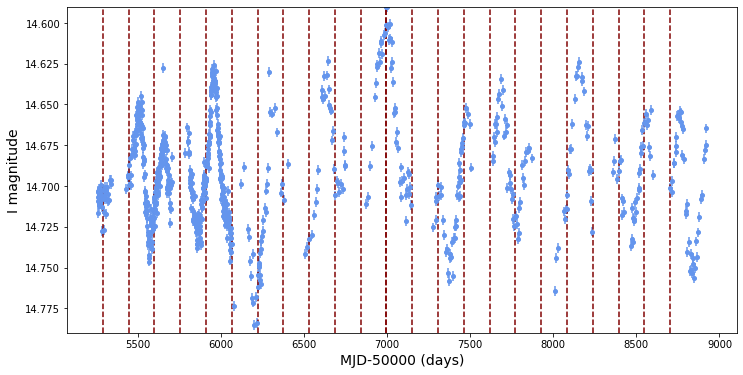

In [23]:
#detrended curve with lines spaced by 155d, measured from middle flare
plt.figure(figsize=(12,6))
plt.errorbar(og4['MJD-50000'],og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
#flipped y axis since showing magnitudes
for i in range(0,12):
    plt.axvline(maxt+i*best_p,0,1,linestyle='dashed',color=c5)
for i in range(0,12):
    plt.axvline(maxt-i*best_p,0,1,linestyle='dashed',color=c5)
plt.ylim(14.75+.04,14.55+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
#plt.tick_params(labelsize=14)


Text(0, 0.5, 'I magnitude')

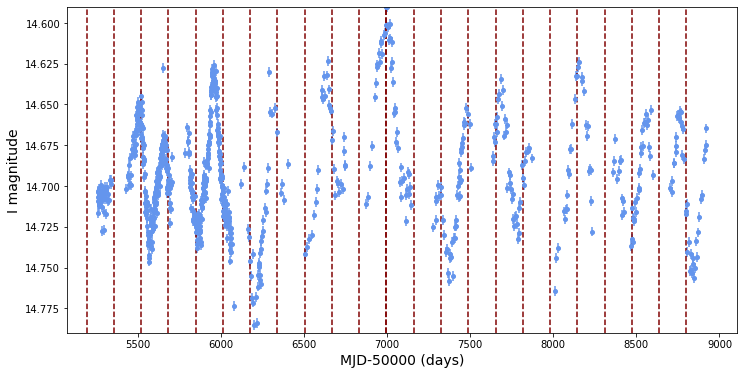

In [24]:
#repeat with 164 days
plt.figure(figsize=(12,6))
plt.errorbar(og4['MJD-50000'],og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
#flipped y axis since showing magnitudes
for i in range(0,12):
    plt.axvline(maxt+i*164,0,1,linestyle='dashed',color=c5)
for i in range(0,12):
    plt.axvline(maxt-i*164,0,1,linestyle='dashed',color=c5)
plt.ylim(14.75+.04,14.55+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)

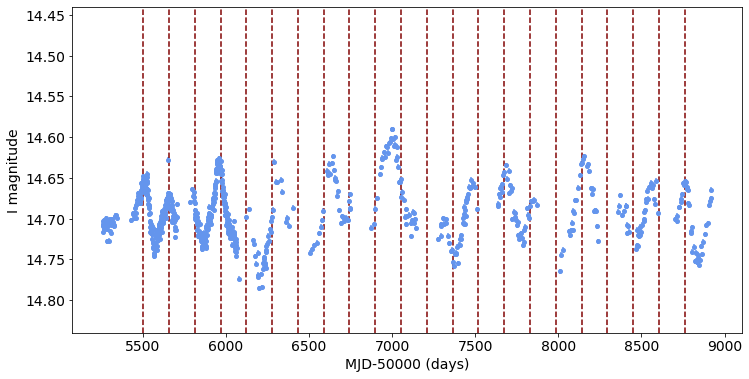

In [25]:
#Ogle IV
#measured from first flare (center found below using Gaussian fit)
plt.figure(figsize=(12,6))
plt.errorbar(og4['MJD-50000'],og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
#flipped y axis since showing magnitudes
for i in range(0,22):
    plt.axvline(5503+i*best_p,0,1,linestyle='dashed',color='maroon')
plt.ylim(14.8+.04,14.4+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
plt.tick_params(labelsize=14)
plt.savefig('155wrong.png',dpi=200,bbox_inches='tight')

> We see that 164 is too high of a period in the beginning and too low at the end. No single period value will predict the flares well. 155 is a good predictor for the first few flares, which have dense data, but is too short for most of the flares.

# 4. To Confirm: Try Multiple Periods
although we can already tell that there isn't a great option since there is a region of underestimation and a region of overestimation, we can still check if there's a decent compromise.

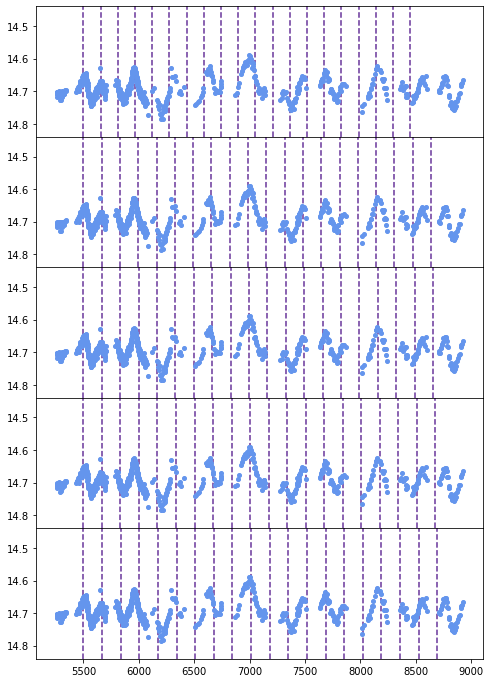

In [26]:
#can try multiple periods here
fig,ax=plt.subplots(5,1,figsize=(8,12),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)
ax[0].errorbar(og4['MJD-50000'],og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
for i in range(20):
    ax[0].axvline(5501+i*best_p,0,1,linestyle='dashed',color=c3)
plt.ylim(14.8+.04,14.4+.04)
ax[1].errorbar(og4['MJD-50000'],og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
for i in range(20):
    ax[1].axvline(5501+i*165,0,1,linestyle='dashed',color=c3)
ax[2].errorbar(og4['MJD-50000'],og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
for i in range(20):
    ax[2].axvline(5501+i*166,0,1,linestyle='dashed',color=c3)
ax[3].errorbar(og4['MJD-50000'],og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
for i in range(20):
    ax[3].axvline(5501+i*167,0,1,linestyle='dashed',color=c3)
ax[4].errorbar(og4['MJD-50000'],og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
for i in range(20):
    ax[4].axvline(5501+i*168,0,1,linestyle='dashed',color=c3)

> periods around 164 can work decently well for many flares, but they are not trustworthy if the goal is prediction, especially considering that their effectiveness completely falls apart in recent years.

# 5. Identify Each Peak

In [27]:
og4[170:190]

JD   I mag  I mag err          MJD   MJD-50000  I detrend 2  \
170  2.455614e+06  14.743      0.003  55613.17037  5613.17037    14.701674   
171  2.455615e+06  14.739      0.003  55614.16272  5614.16272    14.697460   
172  2.455616e+06  14.733      0.003  55615.15611  5615.15611    14.691196   
173  2.455617e+06  14.734      0.003  55616.17214  5616.17214    14.691933   
174  2.455620e+06  14.759      0.003  55619.15402  5619.15402    14.716764   
175  2.455623e+06  14.748      0.003  55622.15556  5622.15556    14.705515   
176  2.455624e+06  14.747      0.003  55623.11492  5623.11492    14.704301   
177  2.455625e+06  14.741      0.003  55624.05615  5624.05615    14.698017   
178  2.455626e+06  14.747      0.003  55625.14764  5625.14764    14.703779   
179  2.455627e+06  14.739      0.003  55626.10871  5626.10871    14.695530   
180  2.455628e+06  14.732      0.003  55627.07352  5627.07352    14.688266   
181  2.455630e+06  14.735      0.003  55629.11369  5629.11369    14.690992   
182  2.455631e+06  14.740      0.003  55630.12510  5630.12510    14.695689   
183  2.455633e+06  14.737      0.003  55632.07329  5632.07329    14.692415   
184  2.455634e+06  14.739      0.003  55633.12219  5633.12219    14.694231   
185  2.455635e+06  14.728      0.003  55634.08269  5634.08269    14.683027   
186  2.455636e+06  14.739      0.003  55635.08696  5635.08696    14.693853   
187  2.455639e+06  14.745      0.003  55638.09156  5638.09156    14.699749   
188  2.455640e+06  14.732      0.003  55639.10181  5639.10181    14.686639   
189  2.455641e+06  14.731      0.003  55640.04075  5640.04075    14.685465   

     phase 155  phase 164  
170  29.798838   37.17037  
171  30.791188   38.16272  
172  31.784578   39.15611  
173  32.800608   40.17214  
174  35.782488   43.15402  
175  38.784028   46.15556  
176  39.743388   47.11492  
177  40.684618   48.05615  
178  41.776108   49.14764  
179  42.737178   50.10871  
180  43.701988   51.07352  
181  45.742158   53.11369  
182  46.753568   54.12510  
183  48.701758   56.07329  
184  49.750658   57.12219  
185  50.711158   58.08269  
186  51.715428   59.08696  
187  54.720028   62.09156  
188  55.730278   63.10181  
189  56.669218   64.04075

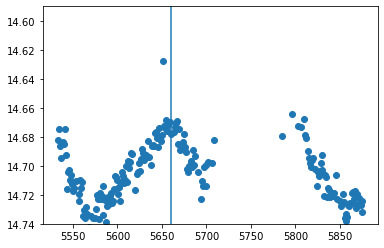

In [28]:
#plt.figure(figsize=(10,6))
plt.scatter(og4['MJD-50000'][100:300],og4['I detrend 2'][100:300])
plt.ylim(14.7+.04,14.55+.04)
plt.axvline(5660,0,1) #by-eye center determination

### Quickly Getting a Sense of Period in Different Regions
then return to identifying maxima

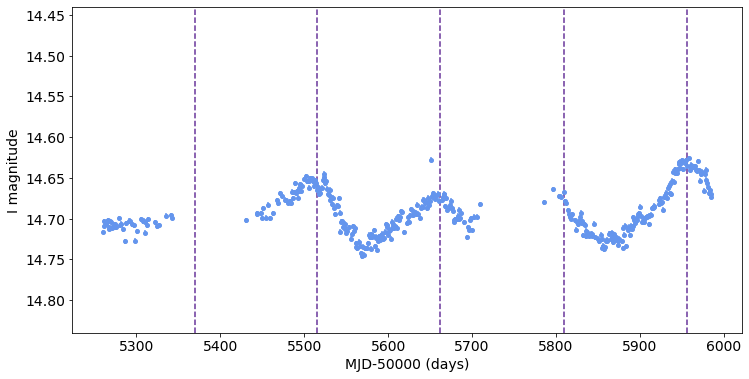

In [29]:
#low period best at beginning of dataset
plt.figure(figsize=(12,6))
plt.errorbar(og4['MJD-50000'][:400],og4['I detrend 2'][:400],yerr=og4['I mag err'][:400],marker='o',markersize=4,linestyle='None',color=c1)

for i in range(4):
    plt.axvline(5515.2+i*147,0,1,linestyle='dashed',color=c3)
plt.axvline(5515.2-145,0,1,linestyle='dashed',color=c3)
#for i in range(20):
    #plt.axvline(5651+i*166,0,1,linestyle='-.',color='rebeccapurple')
plt.ylim(14.8+.04,14.4+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
plt.tick_params(labelsize=14)

Text(0, 0.5, 'I magnitude')

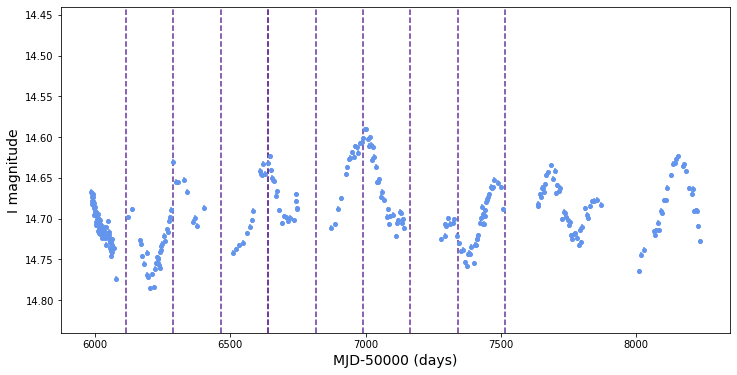

In [30]:
#different start place from above
#higher period needed here
plt.figure(figsize=(12,6))
plt.errorbar(og4['MJD-50000'][400:700],og4['I detrend 2'][400:700],yerr=og4['I mag err'][400:700],marker='o',markersize=4,linestyle='None',color=c1)

for i in range(6):
    plt.axvline(6640+i*175,0,1,linestyle='dashed',color=c3)
for i in range(4):
    plt.axvline(6640-i*175,0,1,linestyle='dashed',color=c3)
#plt.axvline(5515.2-145,0,1,linestyle='dashed',color=c3)
#for i in range(20):
    #plt.axvline(5651+i*166,0,1,linestyle='-.',color='rebeccapurple')
plt.ylim(14.8+.04,14.4+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
#plt.tick_params(labelsize=14)

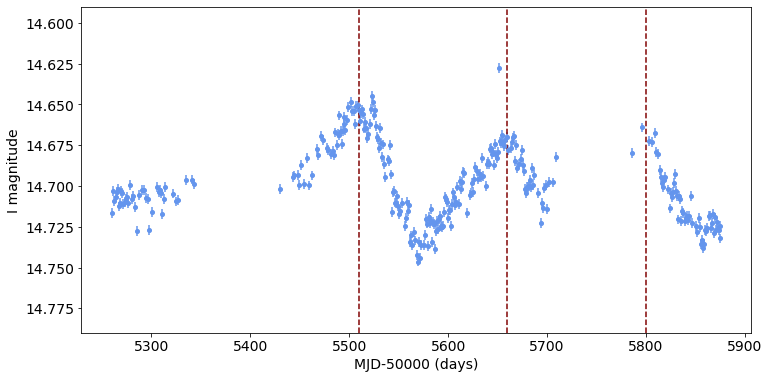

In [31]:
#zooming to estimate centers
plt.figure(figsize=(12,6))
plt.errorbar(og4['MJD-50000'][:300],og4['I detrend 2'][:300],yerr=og4['I mag err'][:300],marker='o',markersize=4,linestyle='None',color=c1)

plt.axvline(5510,0,1,linestyle='dashed',color=c5)
plt.axvline(5660,0,1,linestyle='dashed',color=c5)
plt.axvline(5800,0,1,linestyle='dashed',color=c5)

plt.ylim(14.75+.04,14.55+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
plt.tick_params(labelsize=14)

In [32]:
flaremid=[5510,5660,5800] #approx middles of identifiable flares in MJD-50000

figure out other bounds using table

In [33]:
og4[50:200]

JD   I mag  I mag err          MJD   MJD-50000  I detrend 2  \
50   2.455468e+06  14.710      0.003  55467.35635  5467.35635    14.677370   
51   2.455469e+06  14.714      0.003  55468.34528  5468.34528    14.681230   
52   2.455472e+06  14.702      0.003  55471.36797  5471.36797    14.669090   
53   2.455474e+06  14.705      0.003  55473.30282  5473.30282    14.671951   
54   2.455478e+06  14.710      0.003  55477.30483  5477.30483    14.676811   
..            ...     ...        ...          ...         ...          ...   
195  2.455647e+06  14.734      0.003  55646.02887  5646.02887    14.687296   
196  2.455648e+06  14.721      0.003  55647.03084  5647.03084    14.674181   
197  2.455649e+06  14.728      0.003  55648.03150  5648.03150    14.681067   
198  2.455650e+06  14.730      0.003  55649.04625  5649.04625    14.682958   
199  2.455651e+06  14.726      0.003  55650.02670  5650.02670    14.678828   

     phase 155  phase 164  
50   39.078471   55.35635  
51   40.067401   56.34528  
52   43.090091   59.36797  
53   45.024941   61.30282  
54   49.026951   65.30483  
..         ...        ...  
195  62.657338   70.02887  
196  63.659308   71.03084  
197  64.659968   72.03150  
198  65.674718   73.04625  
199  66.655168   74.02670  

[150 rows x 8 columns]

Text(0, 0.5, 'I magnitude')

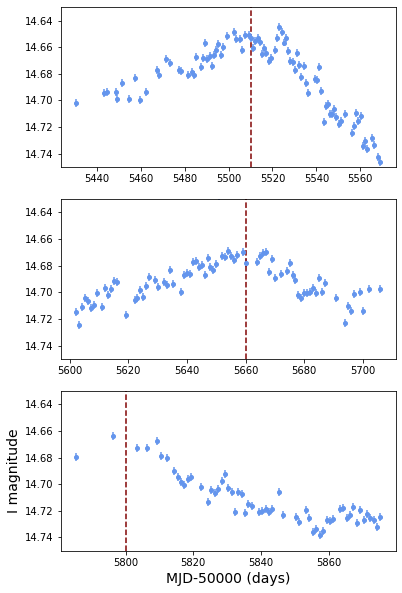

In [34]:
fig,ax=plt.subplots(3,1,sharey=True,figsize=(6,10))

ax[0].errorbar(og4['MJD-50000'][40:130],og4['I detrend 2'][40:130],yerr=og4['I mag err'][40:130],marker='o',markersize=4,linestyle='None',color=c1)
ax[0].axvline(5510,0,1,linestyle='dashed',color='maroon')

ax[1].errorbar(og4['MJD-50000'][160:240],og4['I detrend 2'][160:240],yerr=og4['I mag err'][160:240],marker='o',markersize=4,linestyle='None',color=c1)

ax[1].axvline(5660,0,1,linestyle='dashed',color='maroon')
ax[2].axvline(5800,0,1,linestyle='dashed',color='maroon')
#gap to the left of this point
ax[2].errorbar(og4['MJD-50000'][241:300],og4['I detrend 2'][241:300],yerr=og4['I mag err'][241:300],marker='o',markersize=4,linestyle='None',color=c1)

plt.ylim(14.71+.04,14.59+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
#plt.tick_params(labelsize=14)
#plt.title('First Flare')
#plt.savefig('maximaex.png',dpi=300,bbox_inches='tight')

In [35]:
flareinds = [[40,130],[160,240],[241,300]] #starting list of approx start and ends of flares

Text(0, 0.5, 'I magnitude')

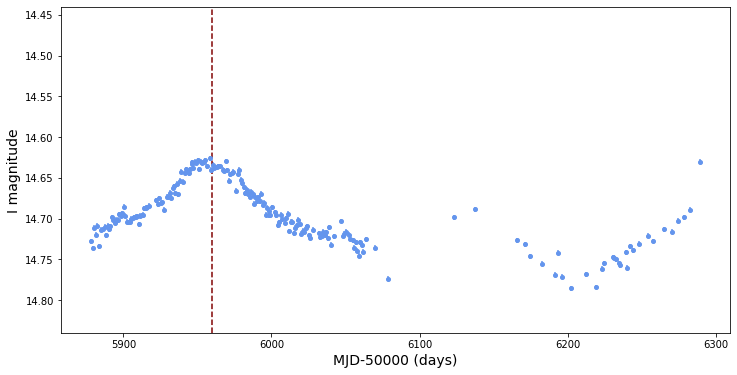

In [36]:
#not going to define other flares within these indices for now; look at predictions for those
plt.figure(figsize=(12,6))
plt.errorbar(og4['MJD-50000'][300:500],og4['I detrend 2'][300:500],yerr=og4['I mag err'][300:500],marker='o',markersize=4,linestyle='None',color=c1)


plt.axvline(5960,0,1,linestyle='dashed',color='maroon')
plt.ylim(14.8+.04,14.4+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
#plt.tick_params(labelsize=14)

Text(0, 0.5, 'I magnitude')

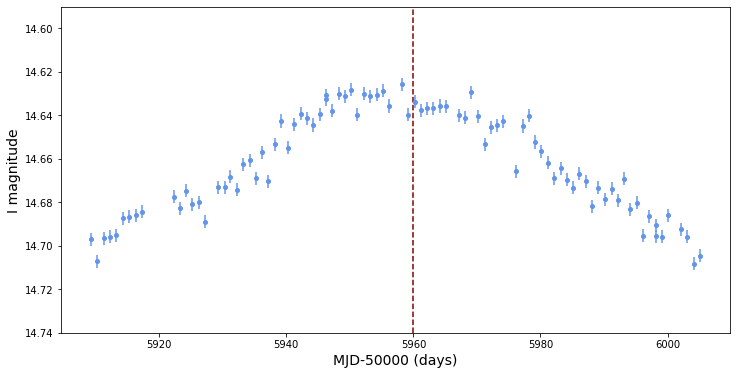

In [37]:
#not going to define other flares within these indices for now; look at predictions for those
plt.figure(figsize=(12,6))
plt.errorbar(og4['MJD-50000'][330:420],og4['I detrend 2'][330:420],yerr=og4['I mag err'][330:420],marker='o',markersize=4,linestyle='None',color=c1)


plt.axvline(5960,0,1,linestyle='dashed',color='maroon')
plt.ylim(14.7+.04,14.55+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
#plt.tick_params(labelsize=14)

In [38]:
flaremid.append(5960)
flareinds.append([330,420])

In [39]:
flareinds

[[40, 130], [160, 240], [241, 300], [330, 420]]

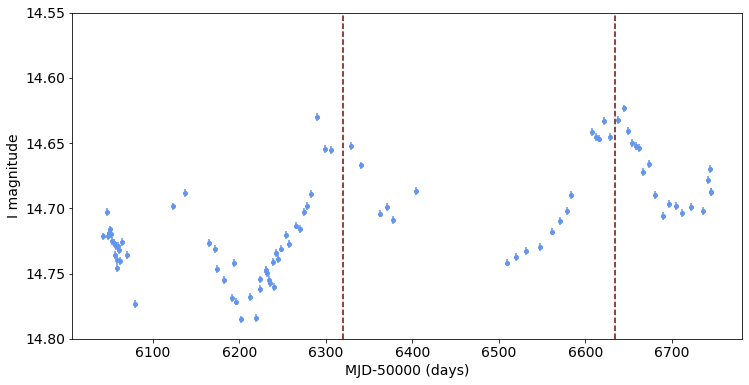

In [40]:
#not going to define other flares within these indices for now; look at predictions for those
plt.figure(figsize=(12,6))
plt.errorbar(og4['MJD-50000'][450:540],og4['I detrend 2'][450:540],yerr=og4['I mag err'][450:540],marker='o',markersize=4,linestyle='None',color=c1)

plt.axvline(6320,0,1,linestyle='dashed',color=c5)
plt.axvline(6635,0,1,linestyle='dashed',color=c5)

plt.ylim(14.8,14.55)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
plt.tick_params(labelsize=14)

In [41]:
flaremid.append(6320)
flaremid.append(6635)

Text(0, 0.5, 'I magnitude')

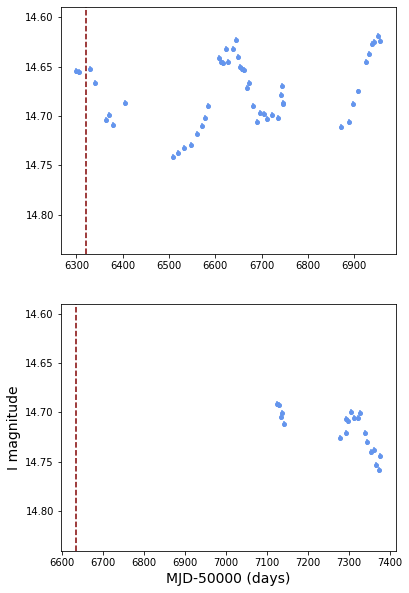

In [42]:
#find start and end indices of each flare between 500 and 700
fig,ax=plt.subplots(2,1,sharey=True,figsize=(6,10))

ax[0].errorbar(og4['MJD-50000'][500:550],og4['I detrend 2'][500:550],yerr=og4['I mag err'][500:550],marker='o',markersize=4,linestyle='None',color=c1)
ax[0].axvline(6320,0,1,linestyle='dashed',color='maroon')

ax[1].errorbar(og4['MJD-50000'][580:600],og4['I detrend 2'][580:600],yerr=og4['I mag err'][580:600],marker='o',markersize=4,linestyle='None',color=c1)

ax[1].axvline(6635,0,1,linestyle='dashed',color='maroon')

plt.ylim(14.8+.04,14.55+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)

## originally thought table wasn't in time order -- really just had duplicates
going to sort by time just in case, but should be equivalent now

In [43]:
#sorted og4
sog4 = og4.sort_values(by='MJD-50000')

Text(0, 0.5, 'I magnitude')

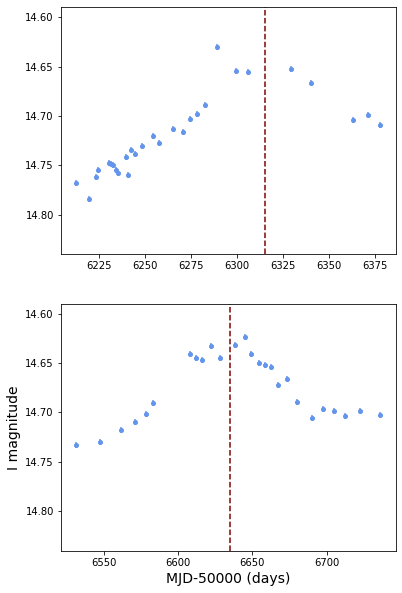

In [44]:
#find start and end indices of each flare between 500 and 700
fig,ax=plt.subplots(2,1,sharey=True,figsize=(6,10))

ax[0].errorbar(sog4['MJD-50000'][478:507],sog4['I detrend 2'][478:507],yerr=sog4['I mag err'][478:507],marker='o',markersize=4,linestyle='None',color=c1)
ax[0].axvline(6315,0,1,linestyle='dashed',color='maroon')

ax[1].errorbar(sog4['MJD-50000'][510:536],sog4['I detrend 2'][510:536],yerr=sog4['I mag err'][510:536],marker='o',markersize=4,linestyle='None',color=c1)

ax[1].axvline(6635,0,1,linestyle='dashed',color='maroon')

plt.ylim(14.8+.04,14.55+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)

In [45]:
flaremid=[5510, 5660, 5800, 5960, 6315, 6635]

In [46]:
flareinds.append([478,507])
flareinds.append([510,536])

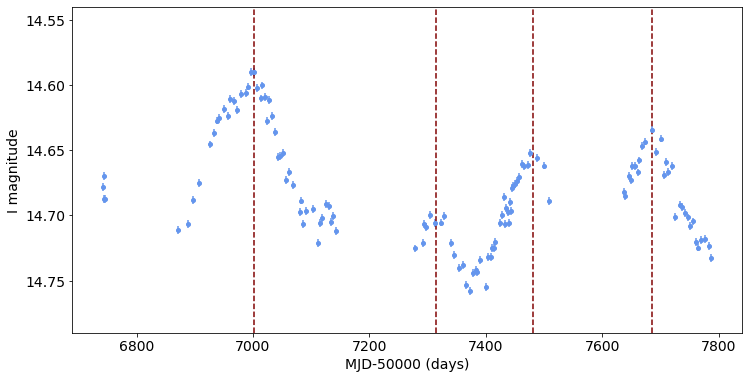

In [47]:
plt.figure(figsize=(12,6))
plt.errorbar(sog4['MJD-50000'][536:660],sog4['I detrend 2'][536:660],yerr=sog4['I mag err'][536:660],marker='o',markersize=4,linestyle='None',color=c1)


plt.axvline(7002,0,1,linestyle='dashed',color='maroon')
plt.axvline(7315,0,1,linestyle='dashed',color='maroon')
plt.axvline(7480,0,1,linestyle='dashed',color='maroon')
plt.axvline(7685,0,1,linestyle='dashed',color='maroon')

#plt.axvline(6635,0,1,linestyle='dashed',color='maroon')

plt.ylim(14.75+.04,14.5+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
plt.tick_params(labelsize=14)

(14.79, 14.54)

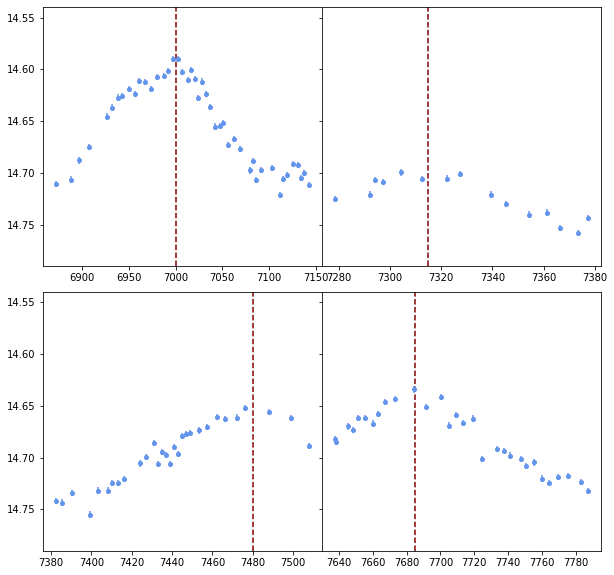

In [48]:
fig,ax=plt.subplots(2,2,sharey=True,figsize=(10,10))
plt.subplots_adjust(wspace=0, hspace=0.1)
ax[0][0].errorbar(sog4['MJD-50000'][540:585],sog4['I detrend 2'][540:585],yerr=sog4['I mag err'][540:585],marker='o',markersize=4,linestyle='None',color=c1)
ax[0][0].axvline(7000,0,1,linestyle='dashed',color=c5)

ax[0][1].errorbar(sog4['MJD-50000'][585:600],sog4['I detrend 2'][585:600],yerr=sog4['I mag err'][585:600],marker='o',markersize=4,linestyle='None',color=c1)
ax[0][1].axvline(7315,0,1,linestyle='dashed',color=c5)

ax[1][0].errorbar(sog4['MJD-50000'][600:630],sog4['I detrend 2'][600:630],yerr=sog4['I mag err'][600:630],marker='o',markersize=4,linestyle='None',color=c1)
ax[1][0].axvline(7480,0,1,linestyle='dashed',color=c5)
#ax[1].axvline(6635,0,1,linestyle='dashed',color='maroon')
ax[1][1].errorbar(sog4['MJD-50000'][630:660],sog4['I detrend 2'][630:660],yerr=sog4['I mag err'][630:660],marker='o',markersize=4,linestyle='None',color=c1)
ax[1][1].axvline(7685,0,1,linestyle='dashed',color=c5)
plt.ylim(14.75+.04,14.5+.04)
#plt.xlabel('MJD-50000 (days)',fontsize=14)
#plt.ylabel('I magnitude',fontsize=14)



In [49]:
flareinds

[[40, 130], [160, 240], [241, 300], [330, 420], [478, 507], [510, 536]]

In [50]:
flareinds.append([540,585])
flareinds.append([585,600])
flareinds.append([600,630])
flareinds.append([630,660])
flaremid.append(7000)
flaremid.append(7315)
flaremid.append(7480)
flaremid.append(7685)

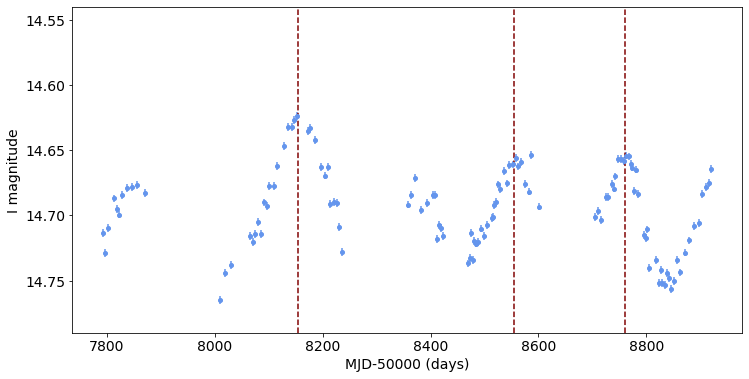

In [51]:
plt.figure(figsize=(12,6))
plt.errorbar(sog4['MJD-50000'][660:],sog4['I detrend 2'][660:],yerr=sog4['I mag err'][660:],marker='o',markersize=4,linestyle='None',color=c1)


plt.axvline(8155,0,1,linestyle='dashed',color=c5)
plt.axvline(8555,0,1,linestyle='dashed',color=c5)
plt.axvline(8760,0,1,linestyle='dashed',color=c5)
#plt.axvline(7685,0,1,linestyle='dashed',color='maroon')

#plt.axvline(6635,0,1,linestyle='dashed',color='maroon')

plt.ylim(14.75+.04,14.5+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
plt.tick_params(labelsize=14)

(14.739999999999998, 14.59)

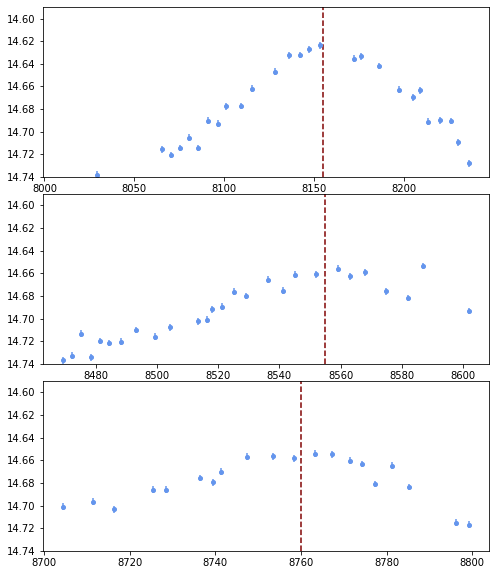

In [52]:
fig,ax=plt.subplots(3,1,sharey=True,figsize=(8,10))
plt.subplots_adjust(wspace=0, hspace=0.1)
ax[0].errorbar(sog4['MJD-50000'][671:700],sog4['I detrend 2'][671:700],yerr=sog4['I mag err'][671:700],marker='o',markersize=4,linestyle='None',color=c1)
ax[0].axvline(8155,0,1,linestyle='dashed',color='maroon')

ax[1].errorbar(sog4['MJD-50000'][711:738],sog4['I detrend 2'][711:738],yerr=sog4['I mag err'][711:738],marker='o',markersize=4,linestyle='None',color=c1)
ax[1].axvline(8555,0,1,linestyle='dashed',color='maroon')

ax[2].errorbar(sog4['MJD-50000'][738:758],sog4['I detrend 2'][738:758],yerr=sog4['I mag err'][738:758],marker='o',markersize=4,linestyle='None',color=c1)
ax[2].axvline(8760,0,1,linestyle='dashed',color='maroon')
#ax[1].axvline(6635,0,1,linestyle='dashed',color='maroon')

plt.ylim(14.7+.04,14.55+.04)

In [53]:
flaremid.append(8155)
flaremid.append(8555)
flaremid.append(8760)

In [54]:
flareinds.append([671,700])
flareinds.append([711,738])
flareinds.append([738,758])

In [55]:
flareinds

[[40, 130],
 [160, 240],
 [241, 300],
 [330, 420],
 [478, 507],
 [510, 536],
 [540, 585],
 [585, 600],
 [600, 630],
 [630, 660],
 [671, 700],
 [711, 738],
 [738, 758]]

# 6. Investigating 13 Identified Flares 
> - so now we have the approximate middle of 13 flares and the start and end indices
- first: all in one plot

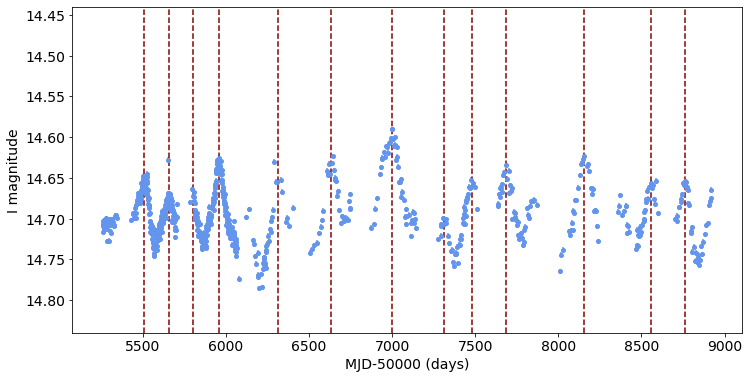

In [56]:
#Ogle IV
plt.figure(figsize=(12,6))
plt.errorbar(sog4['MJD-50000'],sog4['I detrend 2'],yerr=sog4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
for i in flaremid:
    plt.axvline(i,0,1,linestyle='dashed',color=c5)
plt.ylim(14.8+.04,14.4+.04)
plt.xlabel('MJD-50000 (days)',fontsize=14)
plt.ylabel('I magnitude',fontsize=14)
plt.tick_params(labelsize=14)
#plt.savefig('13flareloc.png',dpi=300,bbox_inches='tight')

# differences between consecutive flares

In [57]:
print(flaremid[1]-flaremid[0])
print(flaremid[2]-flaremid[1])
print(flaremid[3]-flaremid[2])
print(flaremid[8]-flaremid[7])
print(flaremid[-4]-flaremid[-5])
print(flaremid[-1]-flaremid[-2])

150
140
160
165
205
205


# 7. Different Epochs With Different Period?
figuring out where to split the data


In [58]:
#first attempt at splitting up the data

#first four known flares and then starting at fifth known flare
r1=sog4[:508]
r2=sog4[508:]

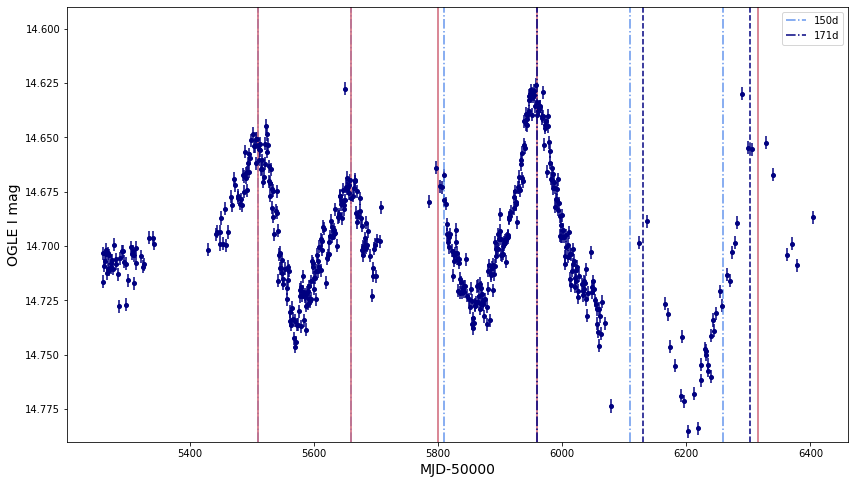

In [59]:
#shows transition from first period to second
plt.figure(figsize=(14,8))
plt.errorbar(r1['MJD-50000'],r1['I detrend 2'],yerr=r1['I mag err'],marker='o',markersize=4,linestyle='None',color=c2)
plt.ylim(14.75+.04,14.55+.04)
plt.axvline(5510,0,1,linestyle='-.',color='cornflowerblue',label='150d')
for i in range(1,6):
    plt.axvline(5510+150*i,0,1,linestyle='-.',color=c1)
for j in range(5):
    plt.axvline(flaremid[j],0,1,color=c4)
plt.axvline(5960,0,1,linestyle='-.',color='navy',label='171d')
for i in range(1,3):
    plt.axvline(5960+171*i,0,1,linestyle='dashed',color=c2)
plt.xlabel('MJD-50000',fontsize=14)
plt.ylabel('OGLE I mag',fontsize=14)
#plt.title('150 Day Period, Starting From 5510d; 171 Day Period From 5960')
plt.legend()
#plt.savefig('150,171r1.png',dpi=300,bbox_inches='tight')

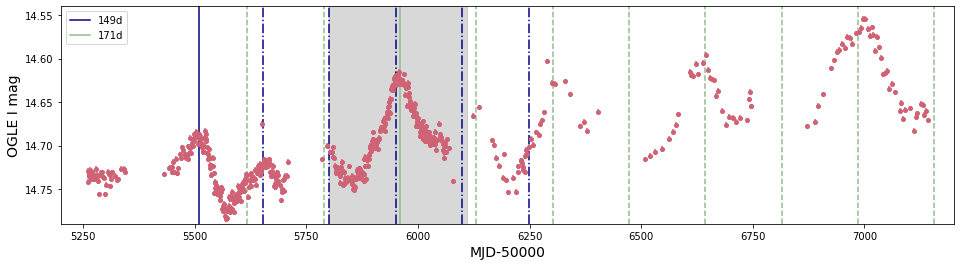

In [60]:
#plot for Overleaf; uses centers found with Gaussian (so update with final model and periods)
plt.figure(figsize=(16,4))
plt.errorbar(sog4['MJD-50000'],sog4['I mag'],yerr=sog4['I mag err'],marker='o',markersize=4,linestyle='None',color='#CF6275')
plt.ylim(14.75+.04,14.54)
plt.xlim(5200,7200)
plt.axvline(5510,0,1,linestyle='solid',color='navy',label='149d')
for i in range(1,6):
    plt.axvline(5503+149*i,0,1,linestyle='-.',color='navy')
#for j in range(5):
    #plt.axvline(flaremid[j],0,1,color=c4)
plt.axvline(5960,0,1,linestyle='solid',color='darkseagreen',label='171d')
for i in [-2,-1,1,2,3,4,5,6,7]:
    plt.axvline(5960+171*i,0,1,linestyle='dashed',color='darkseagreen')
plt.axvspan(5800,6110,color='grey',alpha=.3)
plt.xlabel('MJD-50000',fontsize=14)
plt.ylabel('OGLE I mag',fontsize=14)
#plt.title('150 Day Period, Starting From 5510d; 171 Day Period From 5960')
plt.legend()
#png('firstch')

In [243]:
centers[10]

8160.751256029587

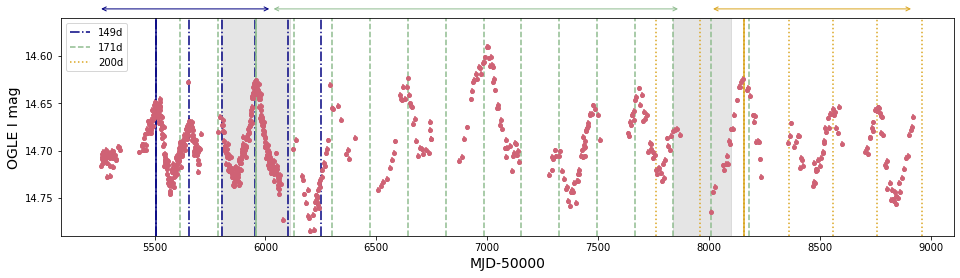

In [246]:
fg = plt.figure(1,figsize=(16,4));
fg.clf();
ax = fg.add_subplot(1,1,1)
ax.errorbar(sog4['MJD-50000'],sog4['I detrend 2'],yerr=sog4['I mag err'],marker='o',markersize=4,linestyle='None',color='#CF6275')
ax.set_ylim(14.75+.04,14.56)
ax.axvline(centers[0],0,1,linestyle='-.',color='navy',label='149d')
ax.axvline(centers[0],0,1,linestyle='solid',color='navy')
for i in range(1,6):
    ax.axvline(centers[0]+149*i,0,1,linestyle='-.',color='navy')
ax.axvline(centers[3],0,1,linestyle='dashed',color='darkseagreen',label='171d')
ax.axvline(centers[3],0,1,linestyle='solid',color='darkseagreen')
for i in [-2,-1,1,2,3,4,5,6,7,8,9,10,11,12,13]:
    ax.axvline(centers[3]+171*i,0,1,linestyle='dashed',color='darkseagreen')
ax.axvspan(5800,6110,color='grey',alpha=.2)
ax.axvspan(7840,8100,color='grey',alpha=.2)
ax.axvline(centers[10],0,1,linestyle='dotted',color='goldenrod',label='200d')
ax.axvline(centers[10],0,1,linestyle='solid',color='goldenrod')

for i in range(-2,5):
    ax.axvline(centers[10]+200*i,0,1,linestyle='dotted',color='goldenrod')
ax.set_xlabel('MJD-50000',fontsize=14)
ax.set_ylabel('OGLE I mag',fontsize=14)
#plt.title('150 Day Period, Starting From 5510d; 171 Day Period From 5960')
ax.legend()
#ax.arrow(5260,14.55,6005-5260,0,clip_on=False,head_width=.01,head_length=.5)


ax.annotate('', xy=(5250, 14.55),xytext=(6026, 14.55), 
            arrowprops=dict(arrowstyle="<->", color='navy'),annotation_clip=False)
ax.annotate('', xy=(6028, 14.55),xytext=(7870, 14.55), 
            arrowprops=dict(arrowstyle="<->", color='darkseagreen'),annotation_clip=False)
ax.annotate('', xy=(8010, 14.55),xytext=(8921, 14.55), 
            arrowprops=dict(arrowstyle="<->", color='goldenrod'),annotation_clip=False)
fg.canvas.draw()
png('3epochs3')

> we can see shift here from around 150 days being the best period to more like 170-175

Text(0, 0.5, 'OGLE I mag')

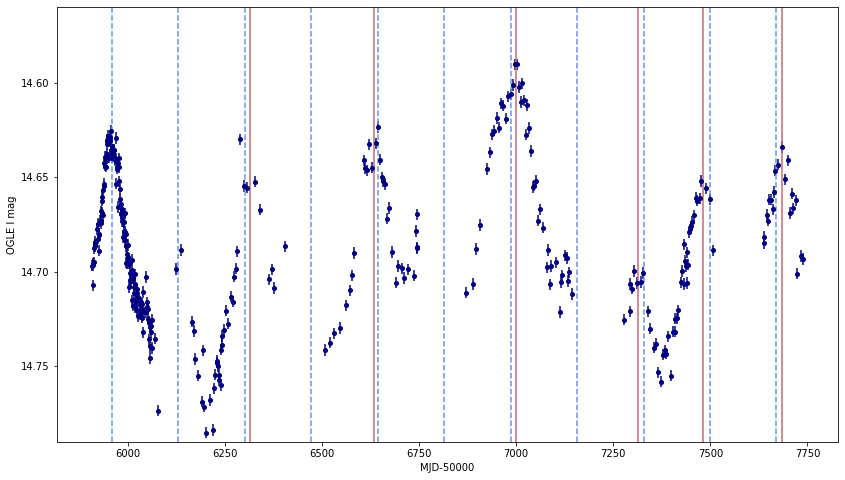

In [62]:
r5=sog4[330:650]
plt.figure(figsize=(14,8))
plt.errorbar(r5['MJD-50000'],r5['I detrend 2'],yerr=r5['I mag err'],marker='o',markersize=4,linestyle='None',color=c2)
plt.ylim(14.75+.04,14.52+.04)
for i in range(11):
    plt.axvline(5960+171*i,0,1,linestyle='dashed',color=c1)
#for i in range(1,3):
    #plt.axvline(7315+170*i,0,1,color='navy')
for j in range(4,10):
    plt.axvline(flaremid[j],0,1,color=c4)
plt.xlabel('MJD-50000')
plt.ylabel('OGLE I mag')
#plt.title('171 Day Period, Starting From 5960d')
#plt.savefig('171r5.png',dpi=300,bbox_inches='tight')

## error as a function of time for r5 (part with ~170 day period)

In [63]:
def errors(pd,st,end,inds):
    pred = np.arange(flaremid[st-1],flaremid[end]+5,pd)
    actual = flaremid[st:end]
    errs=[]
    for i in range(len(inds)):
        err = pred[inds[i]]-actual[i]
        errs.append(err)
        #O-C squared; no division by error
        chis = np.sum(np.array(errs)**2)
    return errs, chis

In [64]:
err70=errors(170,4,10,[2,4,6,8,9,10])
err71=errors(171,4,10,[2,4,6,8,9,10])
err72=errors(172,4,10,[2,4,6,8,9,10])
err73=errors(173,4,10,[2,4,6,8,9,10])
print('170:',err70)
print('171:',err71)
print('172:',err72)
print('173:',err73) #shows 171 is best period, but uncertainty

170: ([-15, 5, -20, 5, 10, -25], 1400)
171: ([-13, 9, -14, 13, 19, -15], 1201)
172: ([-11, 13, -8, 21, 28, -5], 1604)
173: ([-9, 17, -2, 29, 37, 5], 2609)


Text(0, 0.5, 'O-C')

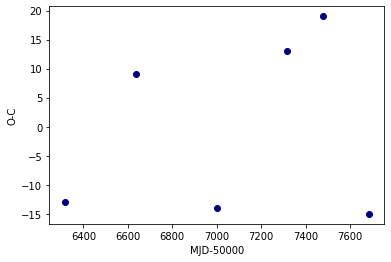

In [65]:
#O-C vs. time shows no trend apparent towards longer period; instead: fluctuations arund 0
plt.scatter(flaremid[4:10],err71[0],color=c2)
plt.xlabel('MJD-50000')
plt.ylabel('O-C')

Text(0, 0.5, 'OGLE I mag')

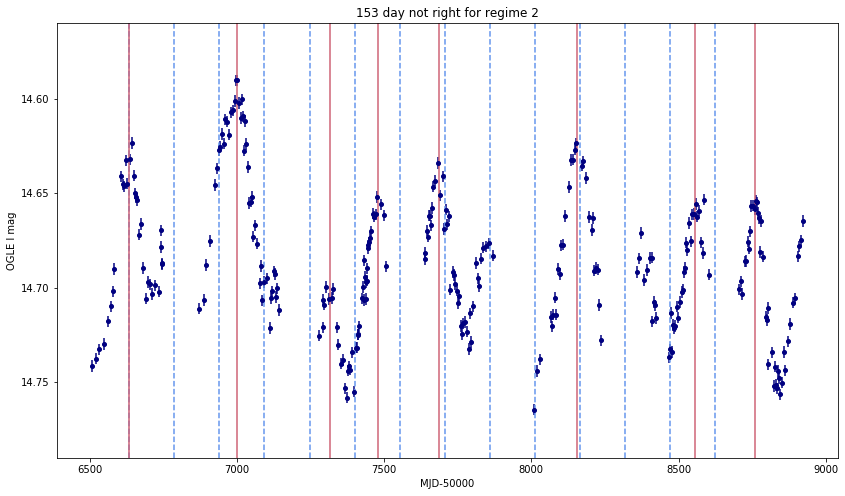

In [66]:
#showing first period ineffective in second epoch
plt.figure(figsize=(14,8))
plt.errorbar(r2['MJD-50000'],r2['I detrend 2'],yerr=r2['I mag err'],marker='o',markersize=4,linestyle='None',color=c2)
plt.ylim(14.75+.04,14.52+.04)
for i in range(14):
    plt.axvline(6635+153*i,0,1,color=c1,linestyle='dashed')
for j in range(5,len(flaremid)):
    plt.axvline(flaremid[j],0,1,color=c4)
plt.title('153 day not right for regime 2')
plt.xlabel('MJD-50000')
plt.ylabel('OGLE I mag')
#plt.savefig('153wrongr2.png',dpi=300,bbox_inches='tight')


Text(0.5, 1.0, '175 Day Period, Starting From 6635d')

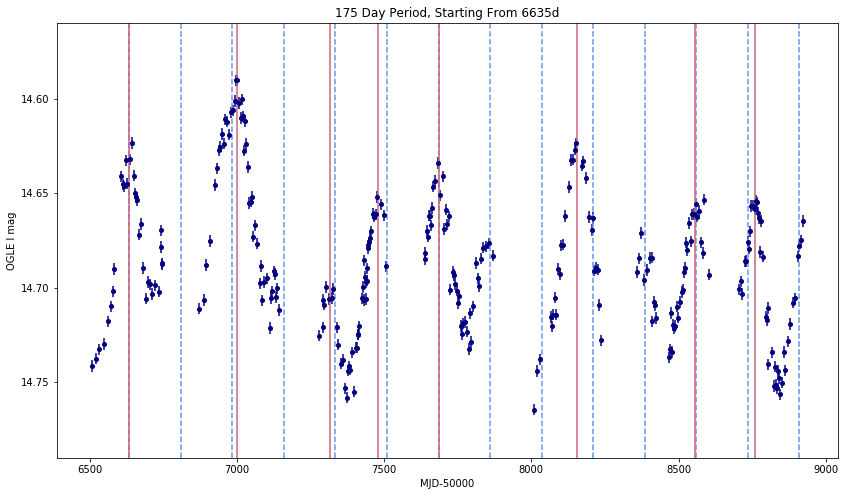

In [67]:
plt.figure(figsize=(14,8))
plt.errorbar(r2['MJD-50000'],r2['I detrend 2'],yerr=r2['I mag err'],marker='o',markersize=4,linestyle='None',color=c2)
plt.ylim(14.75+.04,14.52+.04)
for i in range(14):
    plt.axvline(6635+175*i,0,1,color=c1,linestyle='dashed')
for j in range(5,len(flaremid)):
    plt.axvline(flaremid[j],0,1,color=c4)
plt.xlabel('MJD-50000')
plt.ylabel('OGLE I mag')
plt.title('175 Day Period, Starting From 6635d')
#plt.savefig('175r2.png',dpi=300,bbox_inches='tight')

> break up into three parts

In [68]:
r3=sog4[509:671] #five known flares
r4=sog4[671:]

Text(0.5, 1.0, '171 Day Period, Starting From 6635d')

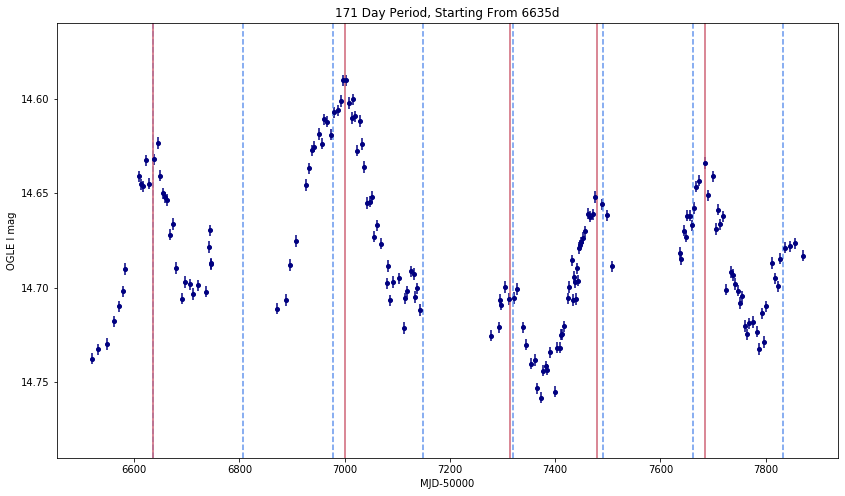

In [69]:
plt.figure(figsize=(14,8))
plt.errorbar(r3['MJD-50000'],r3['I detrend 2'],yerr=r3['I mag err'],marker='o',markersize=4,linestyle='None',color=c2)
plt.ylim(14.75+.04,14.52+.04)
for i in range(8):
    plt.axvline(6635+171*i,0,1,linestyle='dashed',color=c1)
#for i in range(1,3):
    #plt.axvline(7315+170*i,0,1,color='navy')
for j in range(5,10):
    plt.axvline(flaremid[j],0,1,color=c4)
plt.xlabel('MJD-50000')
plt.ylabel('OGLE I mag')
plt.title('171 Day Period, Starting From 6635d')
#plt.savefig('171r3.png',dpi=300,bbox_inches='tight')
#add legend?

Text(0.5, 1.0, '201 Day Period, Starting From 8155d')

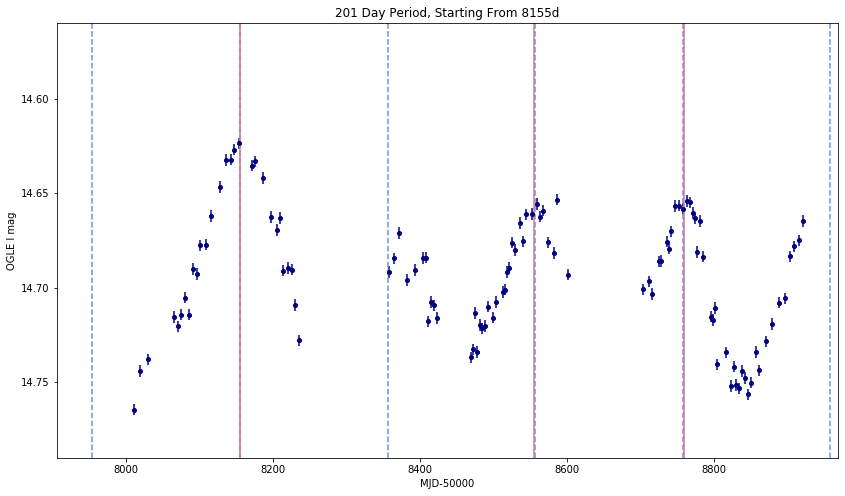

In [70]:
#longest period needed in most recent few flares
plt.figure(figsize=(14,8))
plt.errorbar(r4['MJD-50000'],r4['I detrend 2'],yerr=r4['I mag err'],marker='o',markersize=4,linestyle='None',color='navy')
plt.ylim(14.75+.04,14.52+.04)
for i in range(-1,5):
    plt.axvline(8155+201*i,0,1,linestyle='dashed',color='cornflowerblue')
#for i in range(1,3):
    #plt.axvline(7315+170*i,0,1,color='navy')
for j in range(10,len(flaremid)):
    plt.axvline(flaremid[j],0,1,color='palevioletred')
plt.xlabel('MJD-50000')
plt.ylabel('OGLE I mag')
plt.title('201 Day Period, Starting From 8155d')
#plt.savefig('200r4.png',dpi=300,bbox_inches='tight')

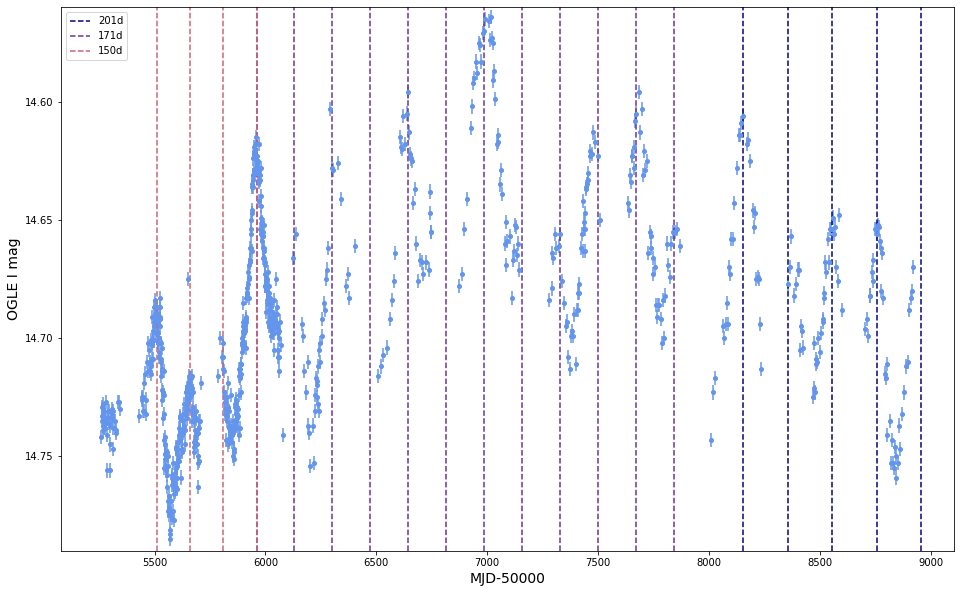

In [71]:
#putting it all together: full lightcurve with three different period values
plt.figure(figsize=(16,10))
plt.errorbar(sog4['MJD-50000'],sog4['I mag'],yerr=sog4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
plt.ylim(14.75+.04,14.52+.04)
plt.axvline(8155,0,1,linestyle='dashed',color=c2,label='201d')
for i in range(1,5):
    plt.axvline(8155+201*i,0,1,linestyle='dashed',color=c2)
plt.axvline(5960,0,1,linestyle='dashed',color=c3,label='171d')
for i in range(1,12):
    plt.axvline(5960+171*i,0,1,linestyle='dashed',color=c3)
plt.axvline(5510,0,1,linestyle='dashed',color=c4,label='150d')
for i in range(1,4):
    plt.axvline(5510+150*i,0,1,linestyle='dashed',color=c4)
#for i in range(len(flaremid)):
    #plt.axvline(flaremid[i],0,1,color=c3)

#for j in range(10,len(flaremid)):
    #plt.axvline(flaremid[j],0,1,color='palevioletred')
plt.xlabel('MJD-50000',fontsize=14)
plt.ylabel('OGLE I mag',fontsize=14)
plt.legend()
#plt.savefig('3pdsalldat2.png',dpi=300,bbox_inches='tight')

## 8. Examine Error of Each Epoch
> - make sure some kind of local minimum
- may not be that significant since error in center determinations
- used this for final determination in plot above
- see further down for chi-squared minimization using centers determined with gaussians

In [72]:
#first
print('149:',errors(149,1,4,[1,2,3]))
err150 = errors(150,1,4,[1,2,3])
print('150:',err150)
print('151:',errors(151,1,4,[1,2,3]))
print('148:',errors(148,1,4,[1,2,3]))
print('152:',errors(152,1,4,[1,2,3]))

149: ([-1, 8, -3], 74)
150: ([0, 10, 0], 100)
151: ([1, 12, 3], 154)
148: ([-2, 6, -6], 76)
152: ([2, 14, 6], 236)


In [73]:
#second
print('170:',errors(170,4,10,[2,4,6,8,9,10]))
err171 = errors(171,4,10,[2,4,6,8,9,10])
print('171:',err171)
print('172:',errors(172,4,10,[2,4,6,8,9,10]))

170: ([-15, 5, -20, 5, 10, -25], 1400)
171: ([-13, 9, -14, 13, 19, -15], 1201)
172: ([-11, 13, -8, 21, 28, -5], 1604)


In [74]:
prd=199
pred = np.arange(flaremid[10],flaremid[-1]+400,prd)
actual = flaremid[11:]
errs=[]
inds=[2,3]
for i in range(len(inds)):
    err = pred[inds[i]]-actual[i]
    errs.append(err)
print('199:',errs)
prd=200
pred = np.arange(flaremid[10],flaremid[-1]+400,prd)
actual = flaremid[11:]
errs=[]
inds=[2,3]
for i in range(len(inds)):
    err = pred[inds[i]]-actual[i]
    errs.append(err)
print('200:',errs)
prd=201
pred = np.arange(flaremid[10],flaremid[-1]+400,prd)
actual = flaremid[11:]
errs201=[]
inds=[2,3]
for i in range(len(inds)):
    err = pred[inds[i]]-actual[i]
    errs201.append(err)
print('201:',errs201)
prd=205
pred = np.arange(flaremid[10],flaremid[-1]+400,prd)
actual = flaremid[11:]
errs=[]
inds=[2,3]
for i in range(len(inds)):
    err = pred[inds[i]]-actual[i]
    errs.append(err)
print('205:',errs)

199: [-2, -8]
200: [0, -5]
201: [2, -2]
205: [10, 10]


> crucially, there's no clear linear pattern of error within any of these three regimes
- 149 better than 150 by-eye

# 9. Phase-Folding and Periodograms by Epoch


In [75]:
reg1=sog4[:440] #440?
reg2=sog4[440:671]
reg3=sog4[671:]

In [76]:
reg2['MJD-50000'][-1:]

742    7869.99276
Name: MJD-50000, dtype: float64

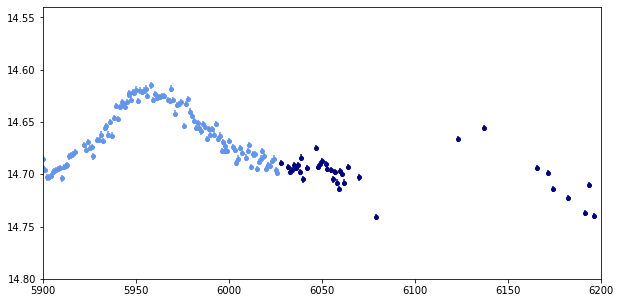

In [77]:
#transition from one to two -- have to decide whether to cut off at end of flare, middle, or other
#flare is predicted by epoch one and used to predict all the peaks of epoch 2
plt.figure(figsize=(10,5))
plt.errorbar(reg1['MJD-50000'],reg1['I mag'],yerr=reg1['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
plt.errorbar(reg2['MJD-50000'],reg2['I mag'],yerr=reg2['I mag err'],marker='o',markersize=4,linestyle='None',color=c2)
plt.xlim(5900,6200)
plt.ylim(14.8,14.54)
png('cutoffe1e2')

[149.01165155447563, 171.62288494174527, 199.05709583291397]

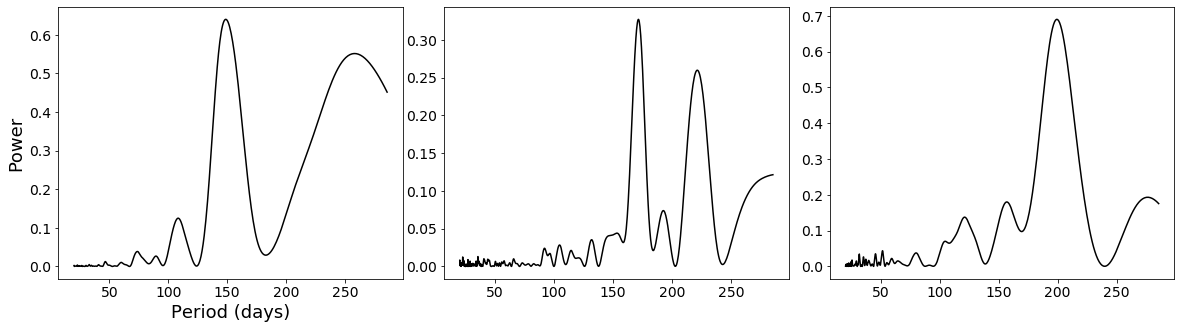

In [78]:
#trying even earlier cutoff
pdsub([0,410,671],[410,671,-1],minf=.0035)
#png('cutoff2gram')

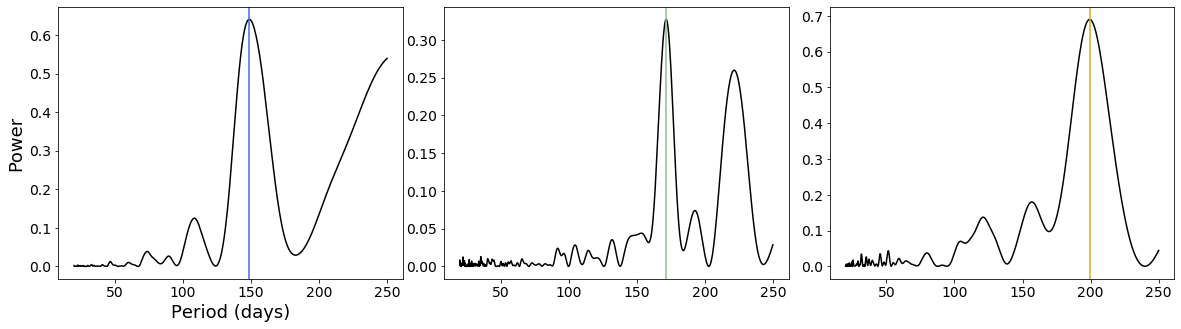

In [325]:
pdsub([0,410,671],[410,671,-1],minf=.004,line=True,c=['royalblue','darkseagreen','goldenrod'])
png('pres3gram')

217.79083643644196


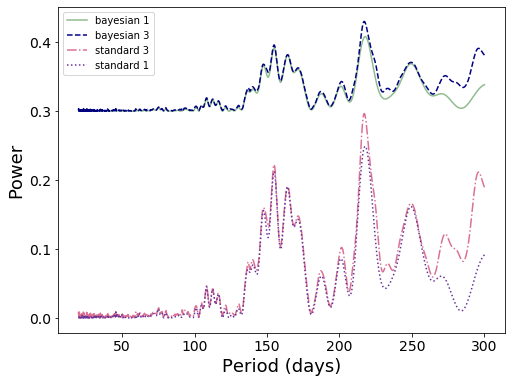

In [80]:
#right now: comparing bayesian 3 terms, bayesian 1 term, standard 3 and 1
plt.figure(figsize=(8,6))
colors = ['darkseagreen','navy','rebeccapurple','palevioletred']
#labs = ['total','first','second','third']
labs = ['bayesian 1','bayesian 3','standard 1','standard 3']
lins = ['solid','dashed','dotted','-.']
st = [0,0,375,671]
end = [-1,375,671,-1]
t = sog4['MJD-50000']
y = sog4['I detrend 2']
y2 = sog4['I mag']
#for s in range(len(st)):
    #if s == 0: 
ls = LombScargle(t[st[0]:end[0]], y[st[0]:end[0]])
    #else: ls = LombScargle(t[st[s]:end[s]], y2[st[s]:end[s]])
freq, power = ls.autopower(normalization='psd',
                           minimum_frequency=1/300,
                           maximum_frequency=.05,
                           samples_per_peak=50) #originally 10
power = np.exp(power)
plt.plot(1/freq,power-.7,color=colors[0],label=labs[0],linestyle=lins[0])

ls = LombScargle(t[st[0]:end[0]], y[st[0]:end[0]],nterms=3)
    #else: ls = LombScargle(t[st[s]:end[s]], y2[st[s]:end[s]])
freq, power = ls.autopower(normalization='psd',
                           minimum_frequency=1/300,
                           maximum_frequency=.05,
                           samples_per_peak=50) #originally 10
power = np.exp(power)
plt.plot(1/freq,power-.7,color=colors[1],label=labs[1],linestyle=lins[1])

ls = LombScargle(t[st[0]:end[0]], y[st[0]:end[0]],nterms=3)
    #else: ls = LombScargle(t[st[s]:end[s]], y2[st[s]:end[s]])
freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=1/300,
                           maximum_frequency=.05,
                           samples_per_peak=50) #originally 10
#power = np.exp(power)
plt.plot(1/freq,power,color=colors[3],label=labs[3],linestyle=lins[3])
ls = LombScargle(t[st[0]:end[0]], y[st[0]:end[0]])
    #else: ls = LombScargle(t[st[s]:end[s]], y2[st[s]:end[s]])
freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=1/300,
                           maximum_frequency=.05,
                           samples_per_peak=50) #originally 10
#power = np.exp(power)
plt.plot(1/freq,power,color=colors[2],label=labs[2],linestyle=lins[2])
best_freq = freq[np.argmax(power)]
print(1/best_freq)
#plt.axvline(1/best_freq,color=colors[0])
plt.tick_params(labelsize=14)
plt.xlabel('Period (days)',fontsize=18)
plt.ylabel('Power',fontsize=18)
plt.legend()
#png('bayestermpd') #nd if three regimes not detrended

In [81]:
#loading in V band data
lv = np.loadtxt('lmc519.22.v.25564.dat',usecols=range(0,3))
lv = pd.DataFrame(lv,columns=['MJD-50000','V mag','V mag err'])
li = sog4

bootstrap false alarm takes awhile so printing results and then hard-coding

In [82]:
#hard-coding bootstrap false alarm
efl = [0.05668714552699862,0.10391627313289417,0.2066185663350531]
bfl = 0.034042922381765435

217.79083643644196
149.21091918154963
171.1859804546096
199.53730244953758


Text(0, 0.5, 'OGLE I mag')

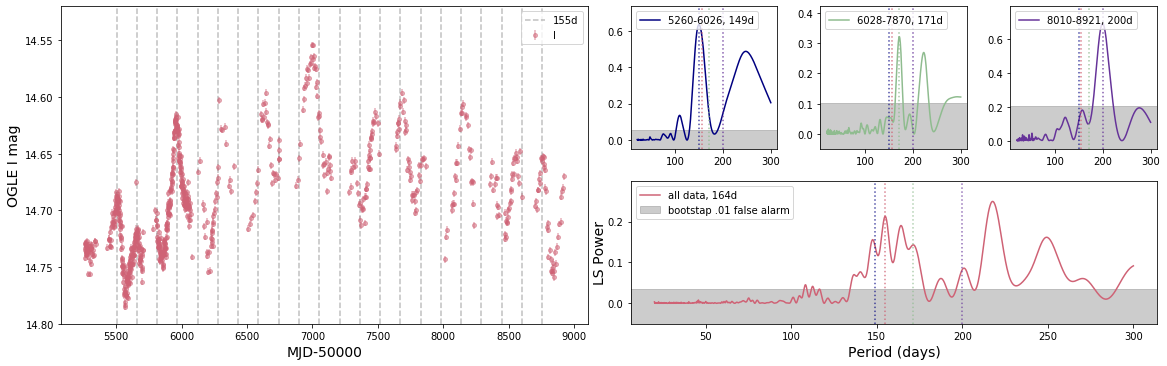

In [83]:
#add subplot version -- adjust heights of plots

fig,ax=plt.subplots(2,6,figsize=(16,5))
fig.tight_layout(w_pad=.9)
gs = ax[0, 0].get_gridspec()
# remove the underlying axes
for a in ax[1, 0:]:
    a.remove()
for a in ax[0, :3]:
    a.remove()
axbig = fig.add_subplot(gs[1, 3:])
axvi = fig.add_subplot(gs[:, :3])
#axvi = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = gs[:,:3], wspace = 1)

#plt.subplots_adjust(hspace=.14,wspace=.2)
colors = ['#CF6275','navy','darkseagreen','rebeccapurple']
labs = ['all data, 164d','5260-6026, 149d','6028-7870, 171d','8010-8921, 200d']
#lins = ['solid','dashed','dotted','-.']
st = [0,0,440,671]
end = [-1,440,671,-1]
t = sog4['MJD-50000']
y = sog4['I detrend 2']
y2 = sog4['I mag']
#epoch false alarms
#efl = [0.06017603227970809,0.0770878648805269,0.204807881794453]
for s in range(len(st)):
    if s == 0: 
        ls = LombScargle(t[st[s]:end[s]], y[st[s]:end[s]])
        freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=1/300,
                           maximum_frequency=.05,
                           samples_per_peak=50) #originally 10
        #power = np.exp(power)
        axbig.plot(1/freq,power,color=colors[0],label=labs[s])
        best_freq = freq[np.argmax(power)]
        print(1/best_freq)
        axbig.axvline(155,color='#CF6275',alpha=.8,linestyle='dotted')
        axbig.axvline(149.21091918154963,color='navy',alpha=.7,linestyle='dotted')
        axbig.axvline(171.1859804546096,color='darkseagreen',alpha=.7,linestyle='dotted')
        axbig.axvline(199.53730244953758,color='rebeccapurple',alpha=.7,linestyle='dotted')
        #fl = ls.false_alarm_level(.01,method='bootstrap')
        #print(fl)
        #adding false alarm value
        axbig.axhspan(-.1,bfl,color='grey',alpha=.4,label='bootstap .01 false alarm')
        axbig.set_ylim(-.05,power.max()+.05)
    else: 
        ls = LombScargle(t[st[s]:end[s]], y[st[s]:end[s]])
        freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=1/300,
                           maximum_frequency=.05,
                           samples_per_peak=50) #originally 10
        #power = np.exp(power)
        ax[0,s+2].plot(1/freq,power,color=colors[s],label=labs[s])
        best_freq = freq[np.argmax(power)]
        print(1/best_freq)
        ax[0,s+2].legend(loc='upper left')
        ax[0,s+2].axvline(155,color='#CF6275',alpha=.8,linestyle='dotted')
        ax[0,s+2].axvline(149.21091918154963,color='navy',alpha=.7,linestyle='dotted')
        ax[0,s+2].axvline(171.1859804546096,color='darkseagreen',alpha=.8,linestyle='dotted')
        ax[0,s+2].axvline(199.53730244953758,color='rebeccapurple',alpha=.8,linestyle='dotted')
        #fl = ls.false_alarm_level(.01,method='bootstrap')
        #print(fl)
        #ax[0,s+2].axhspan(-.1,fl,color='grey',alpha=.4)
        ax[0,s+2].axhspan(-.1,efl[s-1],color='grey',alpha=.4)
        ax[0,s+2].set_ylim(-.05,power.max()+.1)
    #plt.axvline(1/best_freq,color=colors[s])
axbig.legend()
axbig.tick_params(labelsize=10)
axbig.set_yticks([0,.1,.2])
axbig.set_xlabel('Period (days)',fontsize=14)
axbig.set_ylabel('LS Power',fontsize=14,labelpad=1)


axvi.errorbar(li['MJD-50000'],li['I mag'],yerr=li['I mag err'],marker='o',markersize=4,alpha=.5,linestyle='None',color='#CF6275',label='I')
#axvi.errorbar(lv['MJD-50000'],lv['V mag'],yerr=lv['V mag err'],marker='o',markersize=4,alpha=.5,linestyle='None',color='royalblue',label='V')
axvi.set_ylim(14.8,14.52)
for i in range(1,22):
     axvi.axvline(5503+i*155,0,1,linestyle='dashed',color='grey',alpha=.5)
axvi.axvline(5503,0,1,linestyle='dashed',color='grey',alpha=.5,label='155d')
axvi.legend(loc='upper right')
axvi.set_xlabel('MJD-50000',fontsize=14)
axvi.set_ylabel('OGLE I mag',fontsize=14)

#png('lcgram')

217.79083643644196
149.21091918154963
171.1859804546096
199.53730244953758


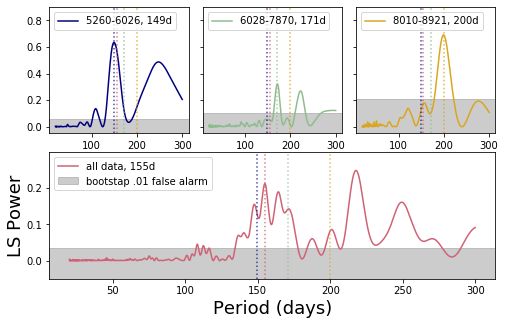

In [84]:
#add subplot version -- adjust heights of plots
from matplotlib import gridspec
fig,ax=plt.subplots(2,3,figsize=(8,5))
gs = ax[0, 0].get_gridspec()
# remove the underlying axes
for a in ax[1, 0:]:
    a.remove()
axbig = fig.add_subplot(gs[1, 0:])
plt.subplots_adjust(hspace=.15,wspace=.1)
colors = ['#CF6275','navy','darkseagreen','goldenrod']
labs = ['all data, 155d','5260-6026, 149d','6028-7870, 171d','8010-8921, 200d']
#lins = ['solid','dashed','dotted','-.']
st = [0,0,440,671]
end = [-1,440,671,-1]
t = sog4['MJD-50000']
y = sog4['I detrend 2']
y2 = sog4['I mag']
for s in range(len(st)):
    if s == 0: 
        ls = LombScargle(t[st[s]:end[s]], y[st[s]:end[s]])
        freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=1/300,
                           maximum_frequency=.05,
                           samples_per_peak=50) #originally 10
        #power = np.exp(power)
        axbig.plot(1/freq,power,color=colors[0],label=labs[s])
        best_freq = freq[np.argmax(power)]
        print(1/best_freq)
        axbig.axvline(155,color='#CF6275',alpha=.8,linestyle='dotted')
        axbig.axvline(149.21091918154963,color='navy',alpha=.7,linestyle='dotted')
        axbig.axvline(171.1859804546096,color='darkseagreen',alpha=.7,linestyle='dotted')
        axbig.axvline(199.53730244953758,color='goldenrod',alpha=.7,linestyle='dotted')
        #fl = ls.false_alarm_level(.01,method='bootstrap')
        axbig.axhspan(-.1,bfl,color='grey',alpha=.4,label='bootstap .01 false alarm')
        axbig.set_ylim(-.05,power.max()+.05)
    else: 
        ls = LombScargle(t[st[s]:end[s]], y[st[s]:end[s]])
        freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=1/300,
                           maximum_frequency=.05,
                           samples_per_peak=50) #originally 10
        #power = np.exp(power)
        ax[0,s-1].plot(1/freq,power,color=colors[s],label=labs[s])
        best_freq = freq[np.argmax(power)]
        print(1/best_freq)
        ax[0,s-1].legend(loc='upper left')
        ax[0,s-1].axvline(155,color='#CF6275',alpha=.8,linestyle='dotted')
        ax[0,s-1].axvline(149.21091918154963,color='navy',alpha=.7,linestyle='dotted')
        ax[0,s-1].axvline(171.1859804546096,color='darkseagreen',alpha=.8,linestyle='dotted')
        ax[0,s-1].axvline(199.53730244953758,color='goldenrod',alpha=.8,linestyle='dotted')
        #fl = ls.false_alarm_level(.01,method='bootstrap')
        ax[0,s-1].axhspan(-.1,efl[s-1],color='grey',alpha=.4)
        ax[0,s-1].set_ylim(-.05,.9)
        if s>1: 
            a=ax[0,0].get_yticks().tolist()
            a=['','','','','','','','']
            ax[0,s-1].set_yticklabels(a)
    #plt.axvline(1/best_freq,color=colors[s])
axbig.legend()
#plt.tick_params(labelsize=14)
axbig.set_xlabel('Period (days)',fontsize=18)
axbig.set_ylabel('LS Power',fontsize=18,labelpad=1)
plt.legend()

#png('4panelpdgramdet')

Text(0, 0.5, 'OGLE I mag')

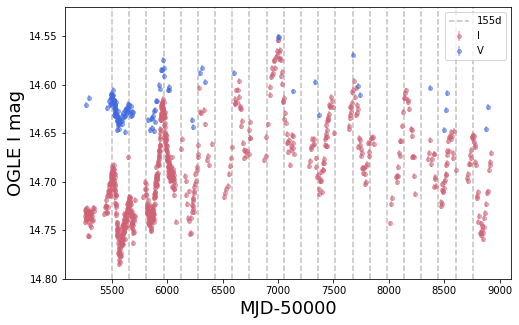

In [85]:
#individual I band
plt.figure(figsize=(8,5))
plt.errorbar(li['MJD-50000'],li['I mag'],yerr=li['I mag err'],marker='o',markersize=4,alpha=.5,linestyle='None',color='#CF6275',label='I')
plt.errorbar(lv['MJD-50000'],lv['V mag'],yerr=lv['V mag err'],marker='o',markersize=4,alpha=.5,linestyle='None',color='royalblue',label='V')
plt.ylim(14.8,14.52)
for i in range(1,22):
     plt.axvline(5503+i*155,0,1,linestyle='dashed',color='grey',alpha=.5)
plt.axvline(5503,0,1,linestyle='dashed',color='grey',alpha=.5,label='155d')
plt.legend(loc='upper right')
plt.xlabel('MJD-50000',fontsize=18)
plt.ylabel('OGLE I mag',fontsize=18)
#png('VI86')

In [247]:
#using error minization values; close to periodogram values, couple days uncertainty
reg1['phase 149'] = reg1['MJD'] % 149.
reg2['phase 171'] = reg2['MJD'] % 171.
reg3['phase 200'] = reg3['MJD'] % 200.

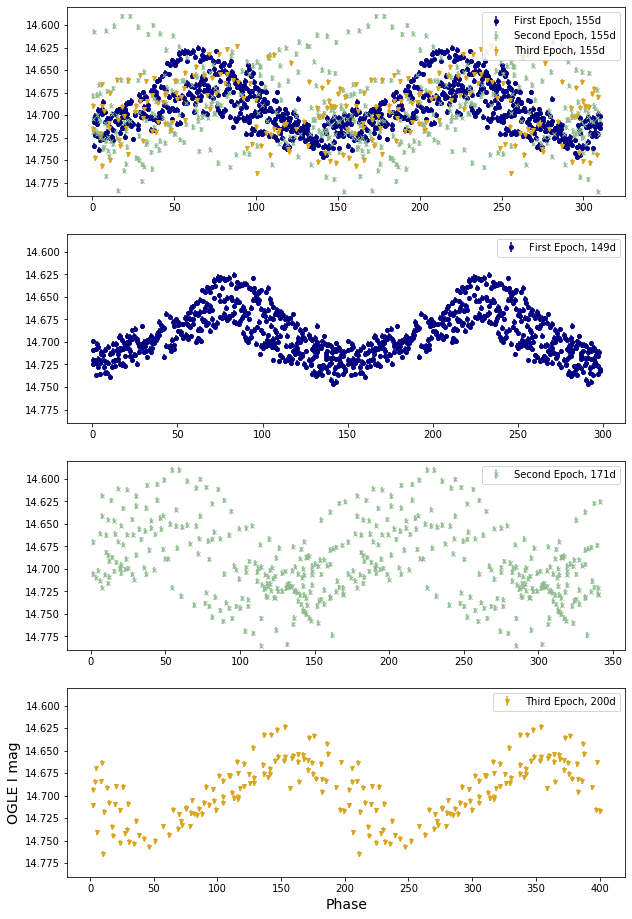

In [248]:
#version up to phase 2
#update with final "best" values
fig,ax=plt.subplots(4,1,sharey=True,figsize=(10,16))
#ax[0].errorbar(og4['phase 164'],og4['I detrend 2'],yerr=og4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1,label='All Data, 164d')
ax[0].errorbar(reg1['phase 155'],reg1['I detrend 2'],yerr=reg1['I mag err'],marker='o',markersize=4,linestyle='None',color='navy',label='First Epoch, 155d')
ax[0].errorbar(reg2['phase 155'],reg2['I detrend 2'],yerr=reg2['I mag err'],marker='x',markersize=4,linestyle='None',color='darkseagreen',label='Second Epoch, 155d')
ax[0].errorbar(reg3['phase 155'],reg3['I detrend 2'],yerr=reg3['I mag err'],marker='v',markersize=4,linestyle='None',color='goldenrod',label='Third Epoch, 155d')
ax[0].errorbar(best_p+reg1['phase 155'],reg1['I detrend 2'],yerr=reg1['I mag err'],marker='o',markersize=4,linestyle='None',color='navy')
ax[0].errorbar(best_p+reg2['phase 155'],reg2['I detrend 2'],yerr=reg2['I mag err'],marker='x',markersize=4,linestyle='None',color='darkseagreen')
ax[0].errorbar(best_p+reg3['phase 155'],reg3['I detrend 2'],yerr=reg3['I mag err'],marker='v',markersize=4,linestyle='None',color='goldenrod')



ax[1].errorbar(reg1['phase 149'],reg1['I detrend 2'],yerr=reg1['I mag err'],marker='o',markersize=4,linestyle='None',color='navy',label='First Epoch, 149d')
ax[1].errorbar(150+reg1['phase 149'],reg1['I detrend 2'],yerr=reg1['I mag err'],marker='o',markersize=4,linestyle='None',color='navy')

ax[2].errorbar(reg2['phase 171'],reg2['I detrend 2'],yerr=reg2['I mag err'],marker='x',markersize=4,linestyle='None',color='darkseagreen',label='Second Epoch, 171d')
ax[2].errorbar(171+reg2['phase 171'],reg2['I detrend 2'],yerr=reg2['I mag err'],marker='x',markersize=4,linestyle='None',color='darkseagreen')

ax[3].errorbar(reg3['phase 200'],reg3['I detrend 2'],yerr=reg3['I mag err'],marker='v',markersize=4,linestyle='None',color='goldenrod',label='Third Epoch, 200d')
ax[3].errorbar(201+reg3['phase 200'],reg3['I detrend 2'],yerr=reg3['I mag err'],marker='v',markersize=4,linestyle='None',color='goldenrod')

ax[3].set_xlabel('Phase',fontsize=14)
ax[3].set_ylabel('OGLE I mag',fontsize=14)
plt.ylim(14.75+.04,14.54+.04)
ax[0].legend();ax[1].legend();ax[2].legend();ax[3].legend()
png('4folds2ph')

## middle part is messiest; not surprising consider super wide flare around 7000 days

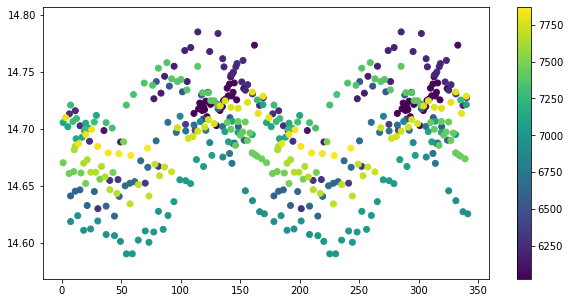

In [88]:
#can see separate flares with colorbar
plt.figure(figsize=(10,5))
plt.scatter(reg2['phase 171'],reg2['I detrend 2'],c=reg2['MJD-50000'],label='Second Regime, 171d')
plt.scatter(171+reg2['phase 171'],reg2['I detrend 2'],c=reg2['MJD-50000'],label='Second Regime, 171d')
plt.colorbar()

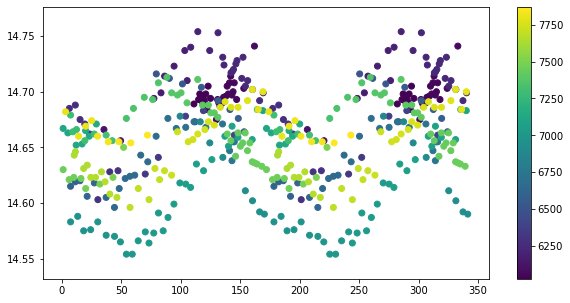

In [89]:
#can see separate flares with colorbar -- original rather than detrended
plt.figure(figsize=(10,5))
plt.scatter(reg2['phase 171'],reg2['I mag'],c=reg2['MJD-50000'],label='Second Regime, 171d')
plt.scatter(171+reg2['phase 171'],reg2['I mag'],c=reg2['MJD-50000'],label='Second Regime, 171d')
plt.colorbar()

> can see separate flares not in phase with each other

# 10. Fitting Flares With Gaussians
fit notebook is LXP69.5FlareModelling
- loading in table and using mid and err

In [90]:
flerr = pd.read_csv('flaremodels.csv')

In [91]:
flerr

Unnamed: 0  gaussian center  med gaussian boot  gaussian stdev  \
0            0      5497.025629        5497.204325        1.557762   
1            1      5653.721665        5654.023445        1.130321   
2            2      5798.592549        5798.807820        3.958331   
3            3      5960.250938        5960.114578        0.430399   
4            4      6318.469159        6319.006304        6.333374   
5            5      6637.294439        6637.178538        2.548994   
6            6      6988.882603        6988.802930        1.469655   
7            7      7313.795244        7313.645432        1.602831   
8            8      7476.981892        7477.215372        3.101398   
9            9      7682.035391        7682.106400        1.538147   
10          10      8155.107214        8155.463403        1.334636   
11          11      8559.433758        8558.943930        5.103452   
12          12      8755.943745        8756.093249        1.593757   

    g+line center  med g+line boot  g+line stdev  triangle center  \
0     5513.343428      5513.567409      1.191667      5516.464173   
1     5657.192761      5657.317247      2.618381      5658.598309   
2     5800.959890      5801.408254      4.431167      5804.141488   
3     5957.653691      5957.797989      0.923187      5956.350574   
4     6309.559311      6309.472096      4.420531      6315.209440   
5     6630.221666      6629.994589      1.812328      6631.191348   
6     6988.826699      6990.408021      4.524363      6997.643335   
7     7316.457984      7316.587507      5.163275      7315.914753   
8             NaN      7447.302102     28.804405      7483.061701   
9     7685.004597      7685.528583      4.238552      7680.745054   
10    8162.566418      8161.003982      6.060537      8164.304913   
11    8556.493081      8551.982787      6.976252      8557.255254   
12    8766.884799      8765.496433      5.595033      8766.011649   

    med triangle boot  triangle stdev  ...     gl+stdev     gl-stdev  \
0         5516.488749        2.928319  ...  5514.535095  5512.151762   
1         5658.904937        2.791627  ...  5659.811142  5654.574380   
2         5803.807992        5.800822  ...  5805.391056  5796.528723   
3         5956.218231        1.184457  ...  5958.576878  5956.730504   
4         6315.586128        7.382521  ...  6313.979842  6305.138780   
5         6630.784682        5.419748  ...  6632.033995  6628.409338   
6         6997.903461        2.921079  ...  6993.351063  6984.302336   
7         7316.445393        5.575132  ...  7321.621259  7311.294708   
8         7475.878457        8.585643  ...          NaN          NaN   
9         7680.907480        3.669549  ...  7689.243150  7680.766045   
10        8164.809499        3.425021  ...  8168.626955  8156.505882   
11        8557.427382        4.434501  ...  8563.469333  8549.516829   
12        8765.701033        2.487078  ...  8772.479832  8761.289766   

            min          max        mingl        maxgl        err      errgl  \
0   5495.467867  5519.392492  5495.467867  5519.392492  11.962313  11.962313   
1   5652.591343  5661.389936  5652.591343  5661.389936   4.399296   4.399296   
2   5794.634218  5809.942310  5794.634218  5809.942310   7.654046   7.654046   
3   5955.166117  5960.681337  5955.166117  5960.681337   2.757610   2.757610   
4   6307.826919  6324.802533  6305.138780  6324.802533   8.487807   9.831876   
5   6625.771599  6639.843433  6625.771599  6639.843433   7.035917   7.035917   
6   6987.412947  7000.564414  6984.302336  7000.564414   6.575733   8.131039   
7   7310.339620  7321.489885  7310.339620  7321.621259   5.575132   5.640819   
8   7473.880495  7491.647344  7473.880495  7491.647344   8.883425   8.883425   
9   7677.075505  7685.004597  7677.075505  7689.243150   3.964546   6.083822   
10  8153.772578  8167.729934  8153.772578  8168.626955   6.978678   7.427189   
11  8552.820754  8564.537210  8549.516829  8564.537210   5.858228   7.510191   
12  875

In [92]:
centers = flerr['mid']
cen_err = flerr['err']

In [93]:
#fix flareinds for half gaussian
flareinds[2] = [241,258]

# 11. Repeat Some Analysis With Gaussian Centers


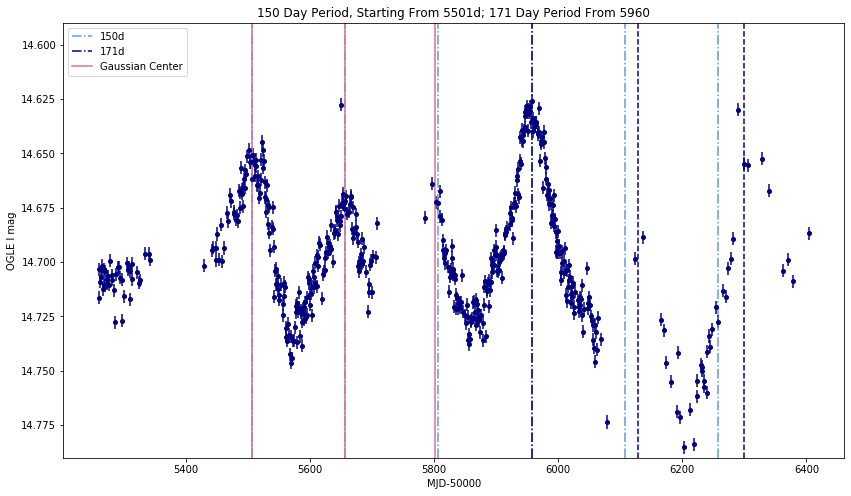

In [94]:
#r1 but with Gaussian lines
plt.figure(figsize=(14,8))
plt.errorbar(r1['MJD-50000'],r1['I detrend 2'],yerr=r1['I mag err'],marker='o',markersize=4,linestyle='None',color='navy')
plt.ylim(14.75+.04,14.55+.04)
plt.axvline(centers[0],0,1,linestyle='-.',color='cornflowerblue',label='150d')
for i in range(1,6):
    plt.axvline(centers[0]+150*i,0,1,linestyle='-.',color='cornflowerblue')
for j in range(1,3):
    plt.axvline(centers[j],0,1,color='palevioletred')
plt.axvline(centers[3],0,1,linestyle='-.',color='navy',label='171d')
plt.axvline(centers[0],0,1,color='palevioletred',label='Gaussian Center')
for i in range(1,3):
    plt.axvline(centers[3]+171*i,0,1,linestyle='dashed',color='navy')
plt.xlabel('MJD-50000')
plt.ylabel('OGLE I mag')
plt.title('150 Day Period, Starting From 5501d; 171 Day Period From 5960')
plt.legend()
#plt.savefig('gaussr1.png',dpi=200,bbox_inches='tight')

Text(0, 0.5, 'OGLE I mag')

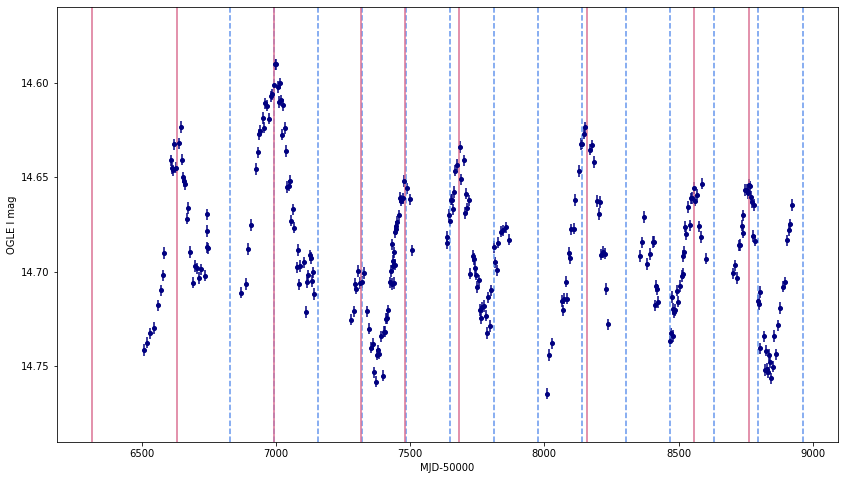

In [95]:
plt.figure(figsize=(14,8))
plt.errorbar(r2['MJD-50000'],r2['I detrend 2'],yerr=r2['I mag err'],marker='o',markersize=4,linestyle='None',color='navy')
plt.ylim(14.75+.04,14.52+.04)
for i in range(-1,13):
    plt.axvline(centers[6]+164*i,0,1,color='cornflowerblue',linestyle='dashed') #predicted
for j in range(4,len(centers)):
    plt.axvline(centers[j],0,1,color='palevioletred')
plt.xlabel('MJD-50000')
plt.ylabel('OGLE I mag')

Text(0.5, 1.0, '171 Day Period, Starting From 6630d')

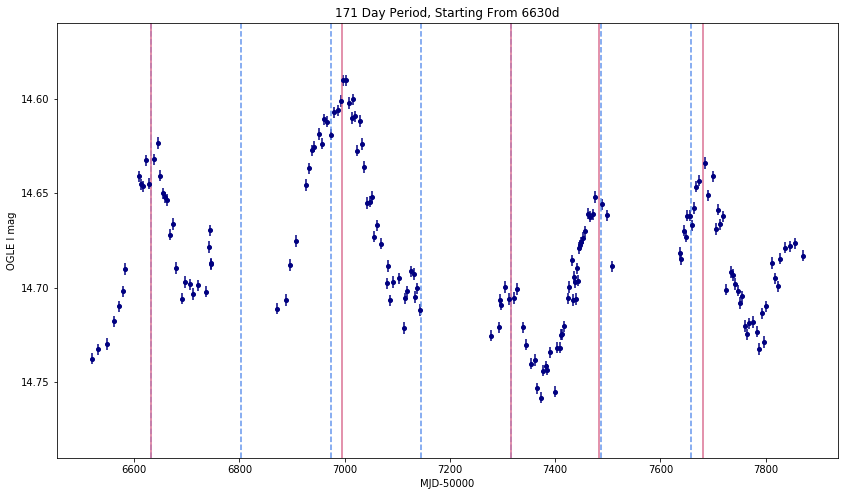

In [96]:
plt.figure(figsize=(14,8))
plt.errorbar(r3['MJD-50000'],r3['I detrend 2'],yerr=r3['I mag err'],marker='o',markersize=4,linestyle='None',color='navy')
plt.ylim(14.75+.04,14.52+.04)
for i in range(7):
    plt.axvline(centers[5]+171*i,0,1,linestyle='dashed',color='cornflowerblue')
#for i in range(1,3):
    #plt.axvline(7315+170*i,0,1,color='navy')
for j in range(4,9):
    plt.axvline(centers[j+1],0,1,color='palevioletred')
plt.xlabel('MJD-50000')
plt.ylabel('OGLE I mag')
plt.title('171 Day Period, Starting From 6630d')

## Best Periods Still 150 and 201?
> maybe 199 or 200?

In [99]:
centers = np.array(centers)
cen_err = np.array(cen_err)

In [100]:
oc1 = ((centers[-3]+199*2)-centers[11])**2
oc2 = ((centers[-3]+199*3)-centers[12])**2
print(oc1+oc2)
oc1 = ((centers[-3]+200*2)-centers[11])**2
oc2 = ((centers[-3]+200*3)-centers[12])**2
print(oc1+oc2)
oc1 = ((centers[-3]+201*2)-centers[11])**2
oc2 = ((centers[-3]+201*3)-centers[12])**2
print(oc1+oc2)
oc1 = ((centers[-3]+202*2)-centers[11])**2
oc2 = ((centers[-3]+202*3)-centers[12])**2
print(oc1+oc2)

13.49689691536415
4.7473855084580565
21.99787410155196
65.24836269464586


Text(0, 0.5, 'OGLE I mag')

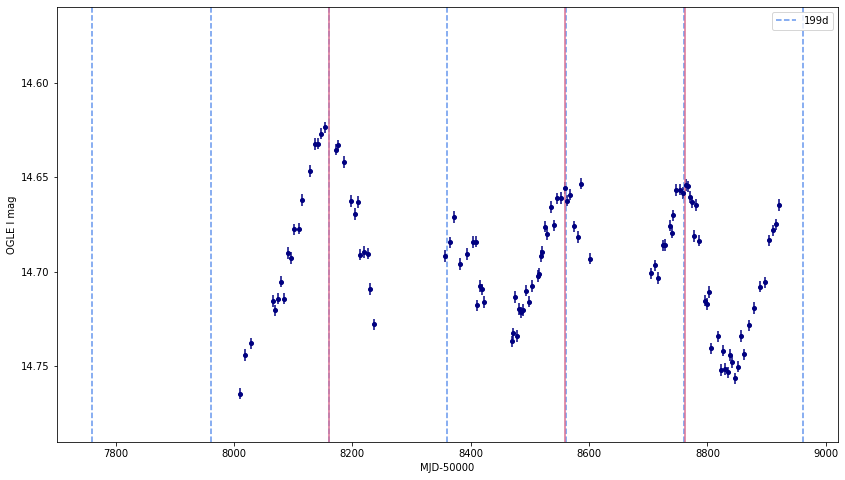

In [102]:
plt.figure(figsize=(14,8))
plt.errorbar(r4['MJD-50000'],r4['I detrend 2'],yerr=r4['I mag err'],marker='o',markersize=4,linestyle='None',color='navy')
plt.ylim(14.75+.04,14.52+.04)
for i in range(-1,5):
    plt.axvline(centers[-3]+200*i,0,1,linestyle='dashed',color='cornflowerblue')
plt.axvline(centers[-3]+200*(-2),0,1,linestyle='dashed',color='cornflowerblue',label='199d')
#for i in range(1,3):
    #plt.axvline(7315+170*i,0,1,color='navy')
for j in range(10,len(centers)):
    plt.axvline(centers[j],0,1,color='palevioletred')
#plt.axvline(centers[7],0,1,color='palevioletred',label='Gaussian Center')
plt.legend()
plt.xlabel('MJD-50000')
plt.ylabel('OGLE I mag')
#plt.savefig('199r4.png',dpi=200,bbox_inches='tight')

Text(0.5, 1.0, '175 Day Period, Starting From 8157d')

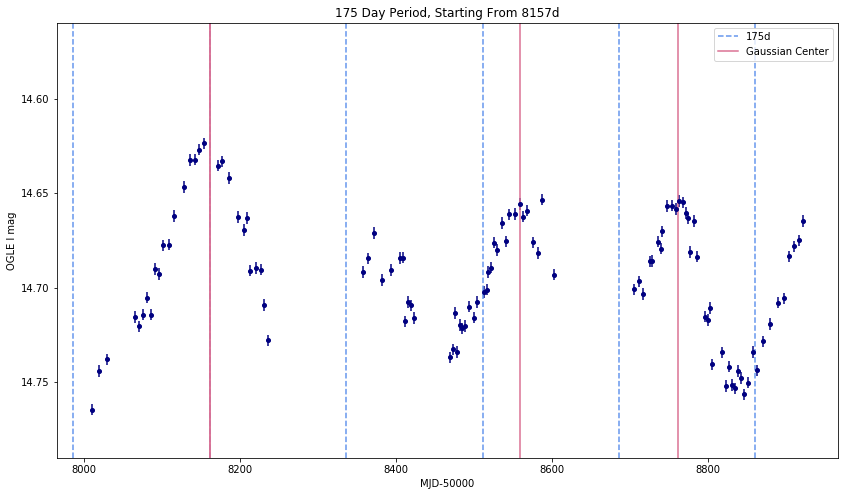

In [103]:
plt.figure(figsize=(14,8))
plt.errorbar(reg3['MJD-50000'],reg3['I detrend 2'],yerr=reg3['I mag err'],marker='o',markersize=4,linestyle='None',color='navy')
plt.ylim(14.75+.04,14.52+.04)
for i in range(-1,5):
    plt.axvline(centers[-3]+175*i,0,1,linestyle='dashed',color='cornflowerblue')
plt.axvline(centers[-3],0,1,linestyle='dashed',color='cornflowerblue',label='175d')
#for i in range(1,3):
    #plt.axvline(7315+170*i,0,1,color='navy')
for j in range(10,len(centers)):
    plt.axvline(centers[j],0,1,color='palevioletred')
plt.axvline(centers[10],0,1,color='palevioletred',label='Gaussian Center')
plt.legend()
plt.xlabel('MJD-50000')
plt.ylabel('OGLE I mag')
plt.title('175 Day Period, Starting From 8157d')
#plt.savefig('175reg3.png',dpi=200,bbox_inches='tight')

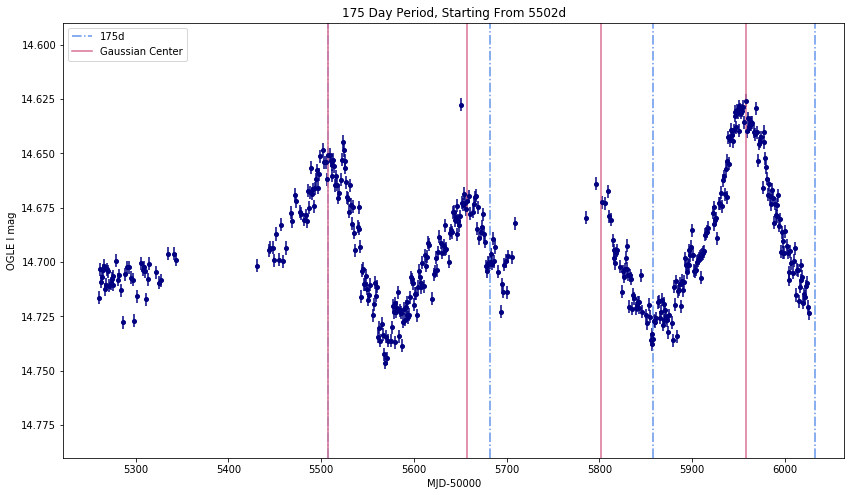

In [104]:
#r1 but with Gaussian lines
plt.figure(figsize=(14,8))
plt.errorbar(reg1['MJD-50000'],reg1['I detrend 2'],yerr=reg1['I mag err'],marker='o',markersize=4,linestyle='None',color='navy')
plt.ylim(14.75+.04,14.55+.04)
plt.axvline(centers[0],0,1,linestyle='-.',color='cornflowerblue',label='175d')
for i in range(1,4):
    plt.axvline(centers[0]+175*i,0,1,linestyle='-.',color='cornflowerblue')
for j in range(1,4):
    plt.axvline(centers[j],0,1,color='palevioletred')
plt.axvline(centers[0],0,1,color='palevioletred',label='Gaussian Center')
plt.xlabel('MJD-50000')
plt.ylabel('OGLE I mag')
plt.title('175 Day Period, Starting From 5502d')
plt.legend()
#plt.savefig('175reg1.png',dpi=200,bbox_inches='tight')

In [107]:
#simple O-C for each epoch
oc1 = ((centers[0]+148)-centers[1])**2
oc2 = ((centers[0]+148*2)-centers[2])**2
oc3 = ((centers[0]+148*3)-centers[3])**2
print(oc1+oc2+oc3)

oc1 = ((centers[0]+149)-centers[1])**2
oc2 = ((centers[0]+149*2)-centers[2])**2
oc3 = ((centers[0]+149*3)-centers[3])**2
print(oc1+oc2+oc3)

oc1 = ((centers[0]+150)-centers[1])**2
oc2 = ((centers[0]+150*2)-centers[2])**2
oc3 = ((centers[0]+150*3)-centers[3])**2
print(oc1+oc2+oc3)

oc1 = ((centers[0]+151)-centers[1])**2
oc2 = ((centers[0]+151*2)-centers[2])**2
oc3 = ((centers[0]+151*3)-centers[3])**2
print(oc1+oc2+oc3)

oc1 = ((centers[0]+152)-centers[1])**2
oc2 = ((centers[0]+152*2)-centers[2])**2
oc3 = ((centers[0]+152*3)-centers[3])**2
print(oc1+oc2+oc3)

oc1 = ((centers[0]+153)-centers[1])**2
oc2 = ((centers[0]+153*2)-centers[2])**2
oc3 = ((centers[0]+153*3)-centers[3])**2
print(oc1+oc2+oc3)


45.90516407737304
22.390623106394553
26.876082135416066
59.36154116443758
119.8470001934591
208.33245922248062


- 149, 200 days first and third

- **put O-C function up above and do each with that, but this is good check for now**

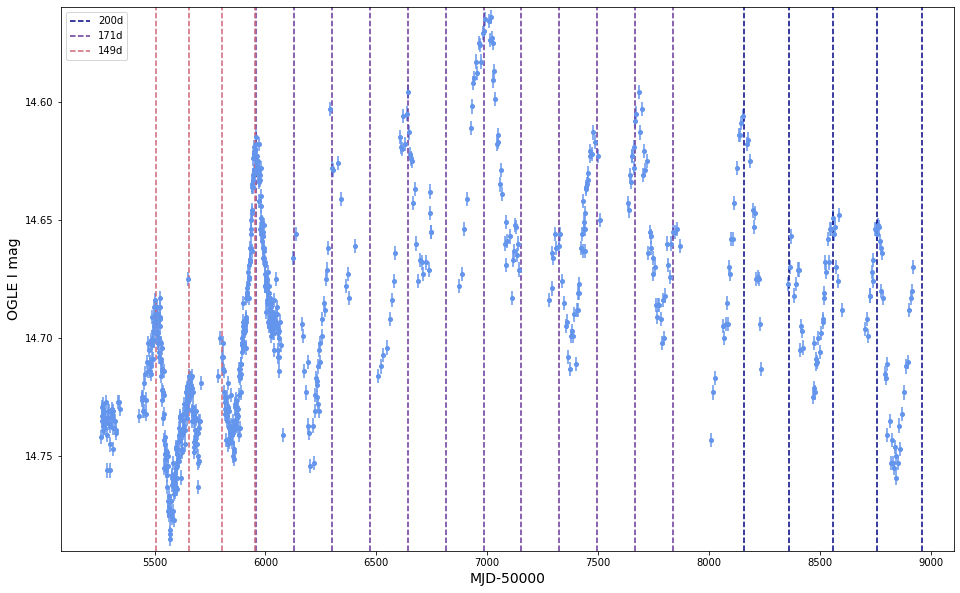

In [238]:
#using best fits from below
plt.figure(figsize=(16,10))
plt.errorbar(sog4['MJD-50000'],sog4['I mag'],yerr=sog4['I mag err'],marker='o',markersize=4,linestyle='None',color=c1)
plt.ylim(14.75+.04,14.52+.04)
plt.axvline(centers[-3],0,1,linestyle='dashed',color=c2,label='200d')
for i in range(1,5):
    plt.axvline(centers[-3]+200*i,0,1,linestyle='dashed',color=c2)
plt.axvline(centers[3],0,1,linestyle='dashed',color=c3,label='171d')
for i in range(1,12):
    plt.axvline(centers[3]+171*i,0,1,linestyle='dashed',color=c3)
plt.axvline(centers[0],0,1,linestyle='dashed',color=c4,label='149d')
for i in range(1,4):
    plt.axvline(centers[0]+149*i,0,1,linestyle='dashed',color=c4)
#for i in range(len(flaremid)):
    #plt.axvline(flaremid[i],0,1,color=c3)

#for j in range(10,len(flaremid)):
    #plt.axvline(flaremid[j],0,1,color='palevioletred')
plt.xlabel('MJD-50000',fontsize=14)
plt.ylabel('OGLE I mag',fontsize=14)
plt.legend()
plt.savefig('3pdsalldatg.png',dpi=300,bbox_inches='tight')

# 12. Plot Flare # vs. Time
look for trend we can fit rather than using three regimes
using error of 10 days on flare centers

In [109]:
#used plot to find numbering of flares for which we have Gaussian-fit centers
flarenum = [0,1,2,3,5,7,9,11,12,13,15,17,18] #can't even be sure around 11 and 15

In [110]:
def parabola(x, a, b, c):
    x = np.array(x)
    return a*x**2 + b*x + c

In [111]:
fit_params, pcov = scipy.optimize.curve_fit(parabola, flarenum, centers)
fit_params

array([2.13831415e+00, 1.41762271e+02, 5.51752844e+03])

In [112]:
y_fit = parabola(flarenum, *fit_params)

In [113]:
#for linear fit, implying constant period
n = np.linspace(0,20)

Text(0, 0.5, 'MJD-50000')

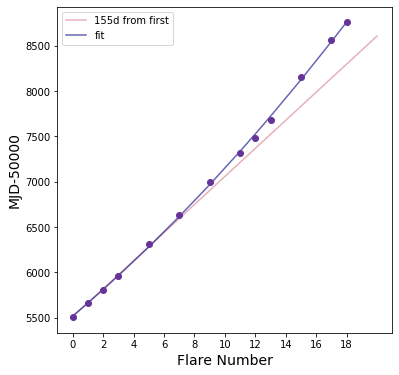

In [114]:
plt.figure(figsize = (6,6))
#flarenum = [0,1,3,5,7,9,11,12,13,15,17,18]
plt.plot(n,(155*n)+centers[0],color=c4,alpha=.5,label='155d from first')
#plt.plot(n,153*n+5501,color='palevioletred')
#plt.plot(n,(centers[-1]-flarenum[-1]*201)+201*x,color='navy',linestyle='dashed',alpha=.5,label='201d from last')
plt.errorbar(flarenum,centers,yerr=cen_err,color=c3,linestyle='none',marker='o')
plt.plot(flarenum, y_fit, color=c2,label='fit',alpha=.6)
plt.legend()
plt.xticks(np.arange(0,20,2))
plt.xlabel('Flare Number',fontsize=14)
plt.ylabel('MJD-50000',fontsize=14)
#plt.savefig('parabtimenum.png',dpi=200,bbox_inches='tight')

In [115]:
flarenum = np.array(flarenum)

Text(0, 0.5, 'Observed Center - Calculated (155d Pd) Center')

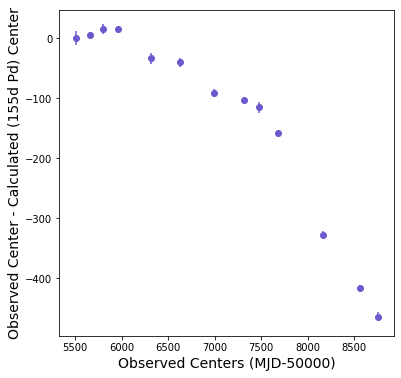

In [117]:
#O-C for 155 days
act_min_pred = [] #actual minus predicted using 164 days
i = 0
for f in flarenum:
    #print(mjd5cens[0]+164*f)
    #print (mjd5cens[i])
    act_min_pred.append(centers[0]+155*f - centers[i])
    i += 1
plt.figure(figsize=(6,6))
x = np.linspace(5500,8600)
plt.errorbar(centers,act_min_pred,xerr=cen_err,yerr=cen_err,linestyle='none',marker='o',color='slateblue')
plt.xlabel('Observed Centers (MJD-50000)',fontsize=14)
plt.ylabel('Observed Center - Calculated (155d Pd) Center',fontsize=14)

## Reverse Axes -- then fit can be used for phase-fold

In [118]:
fit_inv, icov = scipy.optimize.curve_fit(parabola, centers, flarenum)
inv_fit = parabola(centers, *fit_inv)
fit_inv

array([-3.61139471e-07,  1.06686867e-02, -4.78065564e+01])

In [119]:
f = np.linspace(0,20)
fm = 155*f+centers[0]

In [120]:
len(flarenum)

13

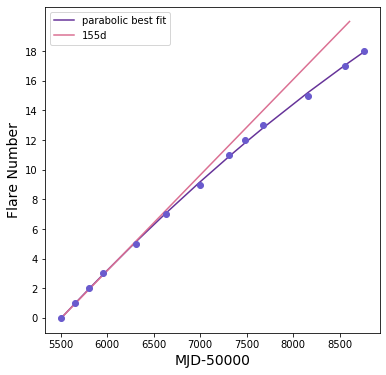

In [121]:
plt.figure(figsize = (6,6))
#plt.plot(n,(164*n)+centers[0],color='palevioletred',alpha=.5,label='164d from first')
#plt.plot(n,153*n+5501,color='palevioletred')
#plt.plot(n,(centers[-1]-flarenum[-1]*201)+201*x,color='navy',linestyle='dashed',alpha=.5,label='201d from last')
plt.plot(centers,inv_fit,color='rebeccapurple',label='parabolic best fit')
plt.errorbar(centers,flarenum,xerr=cen_err,color='slateblue',linestyle='none',marker='o')
plt.yticks(np.arange(0,20,2))
plt.ylabel('Flare Number',fontsize=14)
plt.xlabel('MJD-50000',fontsize=14)
plt.plot(fm,f,color='palevioletred',label='155d')
plt.legend()
plt.savefig('invparabfit.png',dpi=200,bbox_inches='tight')

Text(0, 0.5, 'O-C With Parabolic Fit')

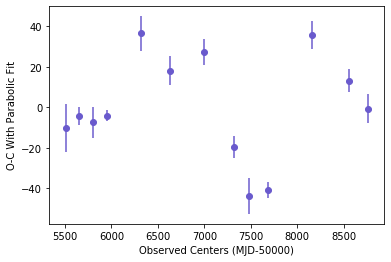

In [122]:
#O-C plot for parabolic fit
inv_fitm = inv_fit % 1
plt.errorbar(centers,centers-y_fit,xerr=cen_err,yerr=cen_err,linestyle='none',marker='o',color='slateblue')
plt.xlabel('Observed Centers (MJD-50000)')
plt.ylabel('O-C With Parabolic Fit')
#plt.savefig('parabo-c.png',dpi=200,bbox_inches='tight')

In [123]:
shift_t = parabola(sog4['MJD-50000'],*fit_inv)
phase_t = shift_t%1

Text(0, 0.5, 'I mag')

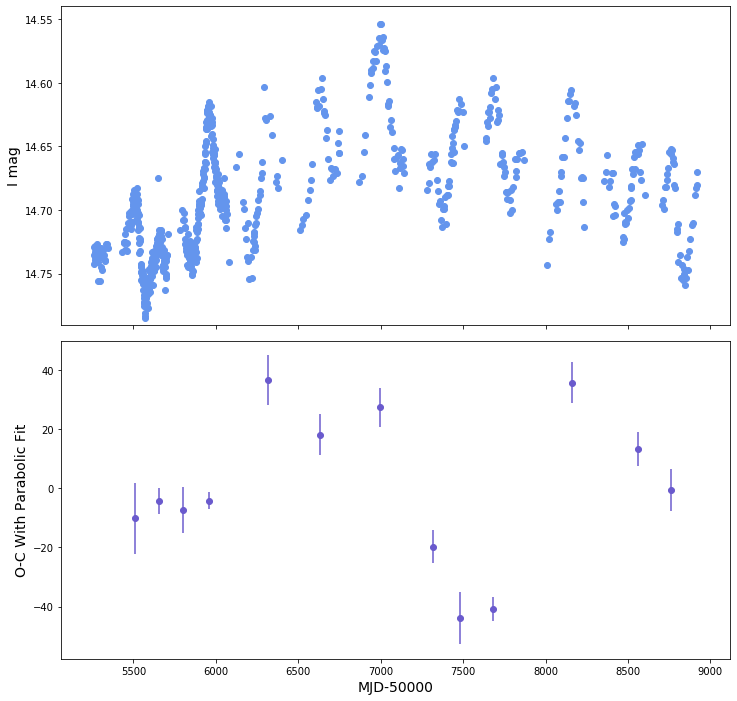

In [124]:
#O-C plot for parabolic fit
fig,ax = plt.subplots(2,1,figsize=(12,12),sharex=True)
inv_fitm = inv_fit % 1
ax[1].errorbar(centers,centers-y_fit,xerr=cen_err,yerr=cen_err,linestyle='none',marker='o',color='slateblue')
ax[1].set_ylabel('O-C With Parabolic Fit',fontsize=14)
ax[0].set_ylim(14.75+.04,14.5+.04)
plt.subplots_adjust(hspace=0.05)
ax[0].scatter(sog4['MJD-50000'],sog4['I mag'],color='cornflowerblue')
# for i in range(20):
#     ax[0].axvline(i,linestyle='dashed',color='slateblue')
ax[1].set_xlabel('MJD-50000',fontsize=14)
ax[0].set_ylabel('I mag',fontsize=14)

#ax[1].set_xlim(5000,9100)
#plt.savefig('o-clc.png',dpi=200,bbox_inches='tight')

Text(0, 0.5, 'I mag')

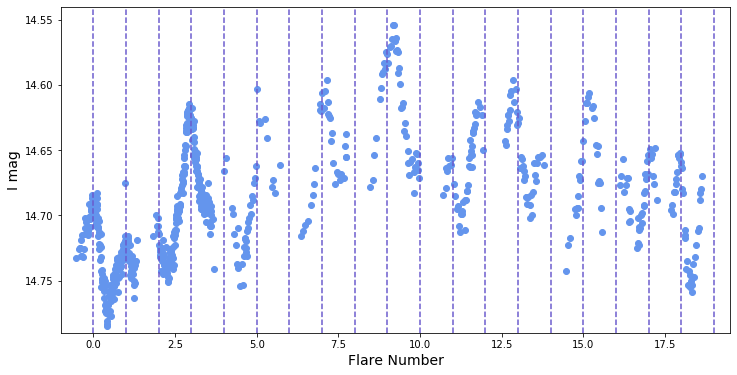

In [125]:
plt.figure(figsize=(12,6))
#plt.scatter(5500+180*shift_t,sog4['I mag'],color='cornflowerblue')
#for i in range(20):
    #plt.axvline(5500+180*i,linestyle='dashed',color='slateblue')
plt.scatter(shift_t,sog4['I mag'],color='cornflowerblue')
for i in range(20):
    plt.axvline(i,linestyle='dashed',color='slateblue')
plt.ylim(14.75+.04,14.5+.04)
plt.xlim(-1,19.5)
plt.xlabel('Flare Number',fontsize=14)
plt.ylabel('I mag',fontsize=14)
#plt.savefig('magtshift.png',dpi=200,bbox_inches='tight')

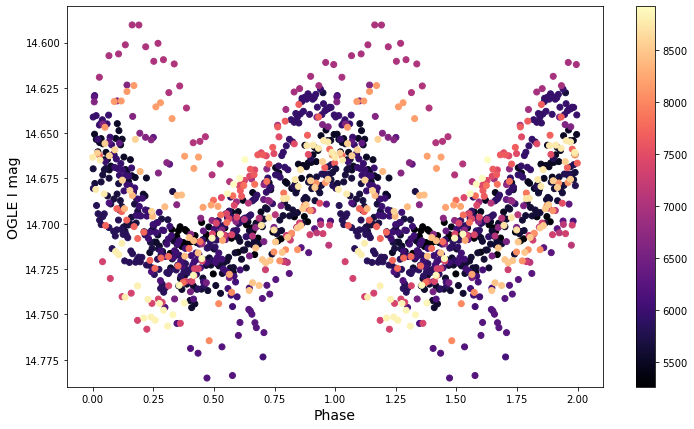

In [127]:
plt.figure(figsize=(12,7))
plt.ylim(14.75+.04,14.54+.04)
plt.scatter(phase_t,sog4['I detrend 2'],c=sog4['MJD-50000'],cmap='magma')
plt.scatter(1+phase_t,sog4['I detrend 2'],c=sog4['MJD-50000'],cmap='magma')
plt.ylabel('OGLE I mag',fontsize=14)
plt.xlabel('Phase',fontsize=14)
plt.colorbar()
png('parabolicperiodcb')

### Trying With Higher-Order Polynomial

In [128]:
def third(x, a, b, c, d):
    x = np.array(x)
    return a*x**3 + b*x**2 + c*x + d

In [129]:
def fourth(x, a, b, c, d, e):
    x = np.array(x)
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

In [130]:
fit_inv2, icov2 = scipy.optimize.curve_fit(third, centers, flarenum)
fit_inv2

array([-3.94166115e-11,  4.83797195e-07,  4.70891437e-03, -3.39817629e+01])

In [131]:
#order three fit for o-c diagram
fit2, cov2 = scipy.optimize.curve_fit(third,flarenum,centers)
yfit2 = third(flarenum,*fit2)

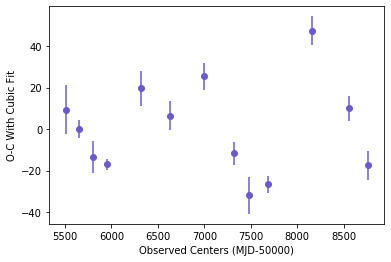

In [133]:
#O-C for order three fit
plt.errorbar(centers,centers-yfit2,xerr=cen_err,yerr=cen_err,linestyle='none',marker='o',color='slateblue')
plt.xlabel('Observed Centers (MJD-50000)')
plt.ylabel('O-C With Cubic Fit') #range of O-C not necessarily better
plt.savefig('cubico-c.png',dpi=200,bbox_inches='tight')

In [134]:
fit_inv3, icov3 = scipy.optimize.curve_fit(fourth, centers, flarenum)
fit_inv3

array([ 4.97133867e-14, -1.45266093e-09,  1.54211053e-05, -6.48542804e-02,
        8.64480926e+01])

In [135]:
shift_t2 = (third(sog4['MJD-50000'],*fit_inv2))%1

In [136]:
shift_t3 = (fourth(sog4['MJD-50000'],*fit_inv3))%1

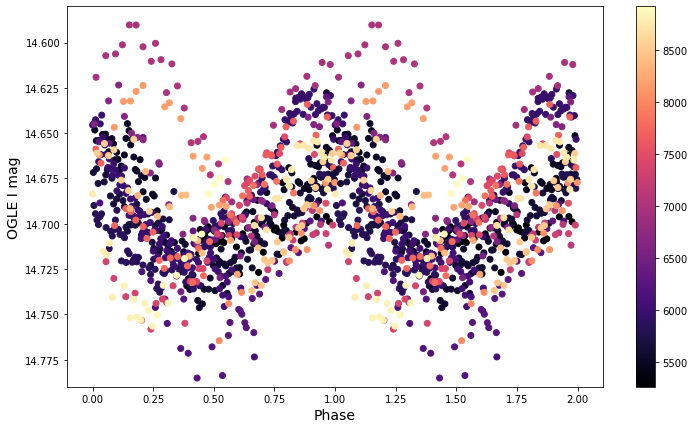

In [137]:
#order 3 polynomial fit
plt.figure(figsize=(12,7))
plt.ylim(14.75+.04,14.54+.04)
plt.scatter(shift_t2,sog4['I detrend 2'],c=sog4['MJD-50000'],cmap='magma')
plt.scatter(1+shift_t2,sog4['I detrend 2'],c=sog4['MJD-50000'],cmap='magma')
plt.ylabel('OGLE I mag',fontsize=14)
plt.xlabel('Phase',fontsize=14)
plt.colorbar()
plt.savefig('orderthreedet.png',dpi=200,bbox_inches='tight')

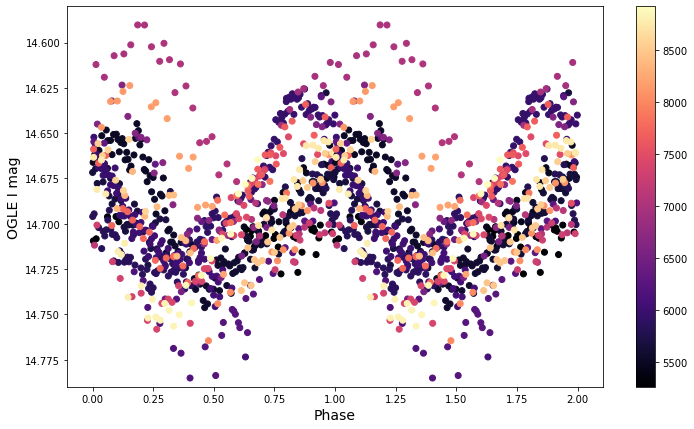

In [138]:
#order four
plt.figure(figsize=(12,7))
plt.ylim(14.75+.04,14.54+.04)
plt.scatter(shift_t3,sog4['I detrend 2'],c=sog4['MJD-50000'],cmap='magma')
plt.scatter(1+shift_t3,sog4['I detrend 2'],c=sog4['MJD-50000'],cmap='magma')
plt.ylabel('OGLE I mag',fontsize=14)
plt.xlabel('Phase',fontsize=14)
plt.colorbar()

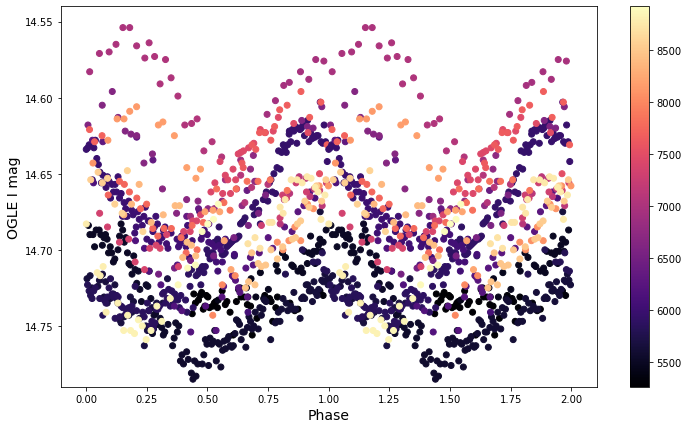

In [139]:
#order three fit
plt.figure(figsize=(12,7))
plt.ylim(14.75+.04,14.5+.04)
plt.scatter(shift_t2,sog4['I mag'],c=sog4['MJD-50000'],cmap='magma')
plt.scatter(1+shift_t2,sog4['I mag'],c=sog4['MJD-50000'],cmap='magma')
plt.ylabel('OGLE I mag',fontsize=14)
plt.xlabel('Phase',fontsize=14)
plt.colorbar()
#plt.savefig('orderthree.png',dpi=200,bbox_inches='tight')

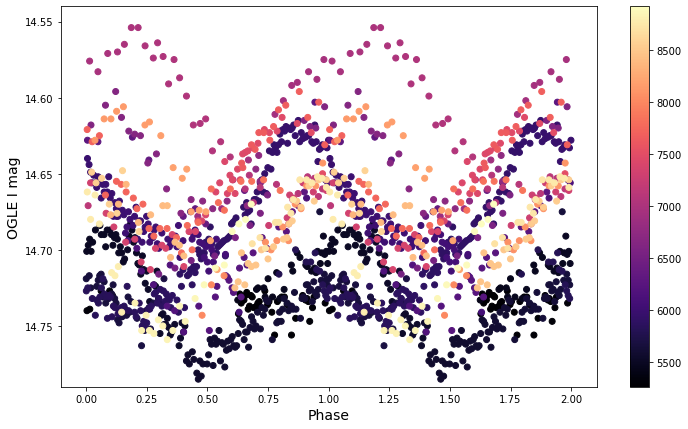

In [140]:
#order 4 fit
plt.figure(figsize=(12,7))
plt.ylim(14.75+.04,14.5+.04)
plt.scatter(shift_t3,sog4['I mag'],c=sog4['MJD-50000'],cmap='magma')
plt.scatter(1+shift_t3,sog4['I mag'],c=sog4['MJD-50000'],cmap='magma')
plt.ylabel('OGLE I mag',fontsize=14)
plt.xlabel('Phase',fontsize=14)
plt.colorbar()

In [141]:
consec = []
for f in range(1,len(flarenum)):
    if flarenum[f] == flarenum[f-1] + 1:
        consec.append(centers[f]-centers[f-1])
consec

[149.56046012521165,
 145.29762409467276,
 155.63546308695186,
 166.84916678593254,
 198.27613176191335,
 202.74537546769716]

# 13. Look At Recent Flares

In [320]:
8844-sog4['MJD-50000'][540:541]

612    1972.56257
Name: MJD-50000, dtype: float64

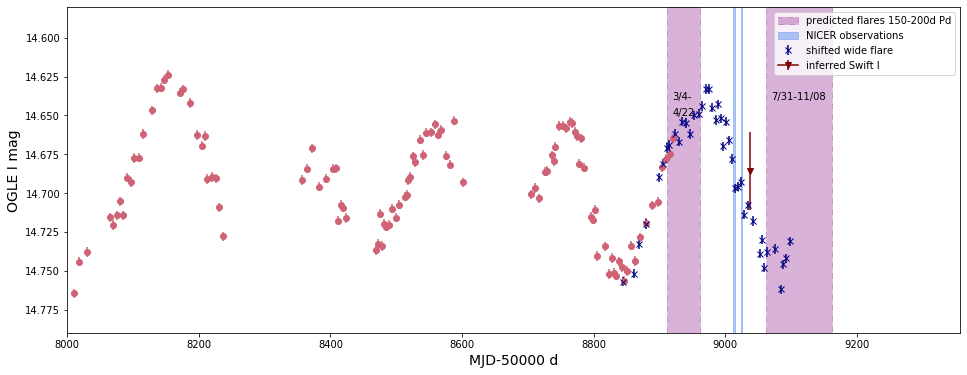

In [321]:
#modifying for presentation
plt.figure(figsize=(16,6))
plt.errorbar(sog4['MJD-50000'],sog4['I detrend 2'],yerr=sog4['I mag err'],linestyle='none',marker='o',color=c4)
# for c in centers[-2:]:
#     plt.axvline(c,0,1,color='palevioletred',linestyle='dashed')
# plt.axvline(centers[-3],0,1,color='palevioletred',linestyle='dashed',label='flare centers')
# plt.axvspan(centers[-1]+150*1,centers[-1]+200*1,color='purple',alpha=.3,linestyle='-.',label='predicted flares 150-200d Pd')
# plt.axvspan(centers[-1]+150*2,centers[-1]+200*2,color='purple',alpha=.3,linestyle='-.')
plt.axvspan(centers[-1]+150*1,centers[-1]+200*1,color='purple',alpha=.3,linestyle='-.',label='predicted flares 150-200d Pd')
plt.axvspan(centers[-1]+150*2,centers[-1]+200*2,color='purple',alpha=.3,linestyle='-.')

plt.text(8920,14.6+.04,'3/4-')
plt.text(8920,14.61+.04,'4/22')
plt.text(9070,14.6+.04,'7/31-11/08')
# plt.axhline(14.575+.04,.417,.558,color='palevioletred')
# plt.text(8625,14.57+.04,'194 days')
#plt.axvline(9015,0,1,color='lightcoral',label='Nicer Observations')
plt.axvspan(9012, 9015, alpha=0.5, color='cornflowerblue',label='NICER observations')
plt.axvspan(9023, 9025, alpha=0.5, color='cornflowerblue')

# plt.axvline(8844,color='black')
# plt.text(8800,14.57+.04,'8844')
plt.errorbar(sog4['MJD-50000'][540:581]+1972.56257,sog4['I mag'][540:581]+.079,yerr=sog4['I mag err'][540:581],linestyle='none',marker='x',color='navy',label='shifted wide flare')
plt.errorbar(9038,14.6857,yerr=.025,color='maroon',marker='v',label='inferred Swift I')
plt.xlim(8000,)
plt.ylim(14.75+.04,14.54+.04)
plt.xlabel('MJD-50000 d',fontsize=14)
plt.ylabel('OGLE I mag',fontsize=14)
plt.legend(loc='upper right')
#plt.savefig('recentflares.png',dpi=300,bbox_inches='tight')
png('presrecentwide')

In [146]:
centers[-1]+400

9161.424357357357

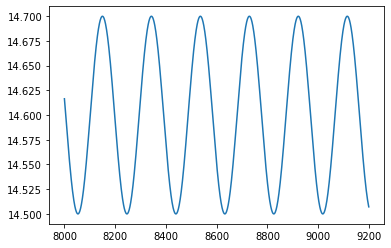

In [150]:
#including sine wave to guide eye
t = np.arange(8000,9200)
plt.plot(t,14.6+.1*np.sin(t/30.7))


(8000, 9000)

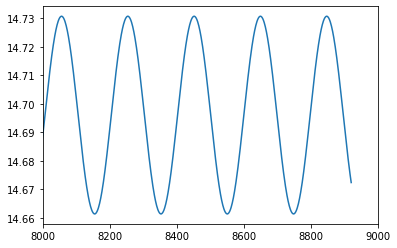

In [151]:
#do an actual sinusoidal fit
t_s = sog4['MJD-50000'][-120:]
t_fit = np.linspace(t_s.min(),t_s.max(),1000)
ls_fit = LombScargle(t_s, sog4['I detrend 2'][-120:], sog4['I mag err'][-120:]).model(t_fit, 1/198)
plt.plot(t_fit,ls_fit)
plt.xlim(8000,9000)

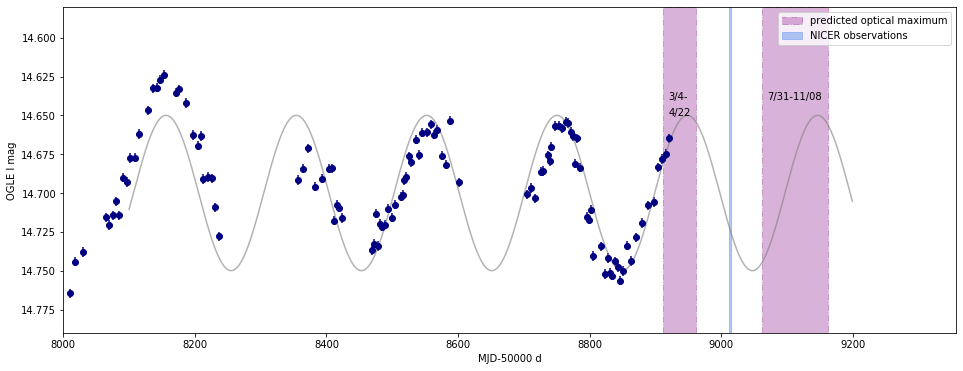

In [154]:
plt.figure(figsize=(16,6))
plt.errorbar(sog4['MJD-50000'],sog4['I detrend 2'],yerr=sog4['I mag err'],linestyle='none',marker='o',color='navy')
#for c in centers[-2:]:
    #plt.axvline(c,0,1,color='palevioletred',linestyle='dashed')
#plt.axvline(centers[-3],0,1,color='palevioletred',linestyle='dashed',label='flare centers')
plt.axvspan(centers[-1]+150*1,centers[-1]+200*1,color='purple',alpha=.3,linestyle='-.',label='predicted optical maximum')
plt.axvspan(centers[-1]+150*2,centers[-1]+200*2,color='purple',alpha=.3,linestyle='-.')

plt.text(8920,14.6+.04,'3/4-')
plt.text(8920,14.61+.04,'4/22')
plt.text(9070,14.6+.04,'7/31-11/08')
#plt.axhline(14.575,.417,.558,color='palevioletred')
#plt.text(8625,14.57,'193 days')
#plt.axvline(9015,0,1,color='lightcoral',label='Nicer Observations')
plt.axvspan(9012, 9015, alpha=0.5, color='cornflowerblue',label='NICER observations')

plt.xlim(8000,)
plt.ylim(14.75+.04,14.54+.04)
plt.xlabel('MJD-50000 d')
plt.ylabel('OGLE I mag')
plt.legend(loc='upper right')
#plt.savefig('annotatedrecentflares.png',dpi=300,bbox_inches='tight')
t = np.arange(8100,9200)
#plt.plot(t,14.66+.05*np.sin(4.8+t/31.67183367528717),color='grey',alpha=.6)
plt.plot(t,14.7+.05*np.sin(3.5+t/31.512678732195276),color='grey',alpha=.6)
#plt.plot(t,14.66+.05*np.sin(2.2+t/31.35352378910338),color='grey',alpha=.6)


#plt.plot(t,14.66+.05*np.sin(2.3+t/31.990143561470965),color='grey',linestyle='dashed')
#plt.plot(t_fit,ls_fit,color='black',alpha=.5) #fit by LombScargle
#plt.savefig('OGLEsine198.png',dpi=300,bbox_inches='tight')


171 days between last minimum and NICER observations

# 14. O-C for Each Regime
to do: clean this up to automatically give answer, to work for third epoch

In [155]:
from uncertainties import ufloat

In [165]:
def gerrors(pd,st,end,inds,sq=False):
    #index of start of prediction (one before first that's predicted)
    #predictions go from center that's fixed
    pred = np.arange(centers[st-1],centers[end]+5,pd)
    #actual start to end in centers
    actual = centers[st:end]
    errs=[]
    for i in range(len(inds)):
        act = actual[i]
        err = actual[i]-pred[inds[i]] #switching to actual - predicted
        errs.append(err)
    #print(np.abs(np.mean(errs)))
    if sq: 
        errs = np.array(errs)
        sumsq = np.sum(errs**2)
        return errs,sumsq
    else: return errs

In [157]:
centers[3]

5957.923726815563

In [158]:
pred

array([8155, 8360, 8565, 8770, 8975])

In [193]:
err151 = gerrors(151,1,4,[1,2,3],sq=True) #first, second, third flares
err149 = gerrors(149,1,4,[1,2,3]) 

err171,sq171 = gerrors(171,4,10,[2,4,6,8,9,10],sq=True)
pred = np.arange(centers[10],centers[-1]+100,201) #predictions for last two centers
actual = centers[11:] #last three centers
errs201 = []
inds = [2,3]
for i in range(len(inds)):
    err = actual[i]-pred[inds[i]]
    errs201.append(err)
errs201

[-4.072274139927686, -2.326898672230527]

In [217]:
#checked that 200 is best
pred = np.arange(centers[10],centers[-1]+100,200) #predictions for last two centers
actual = centers[11:] #last three centers
errs200 = []
inds = [2,3]
for i in range(len(inds)):
    err = actual[i]-pred[inds[i]]
    errs200.append(err)
errs200=np.array(errs200)
print(errs200)
chi200 = errs200**2/cen_err[11:]**2
chi200 = np.sum(chi200)


[-2.07227414  0.67310133]


In [218]:
chi200

0.134182962648797

In [166]:
err170 = gerrors(170,4,10,[2,4,6,8,9,10],sq=True)
err170

(array([18.39099917, -5.11621066, 16.06495392, -2.00897417, -5.15980739,
        23.11632438]),
 1187.5112489276737)

In [168]:
err171

(array([ 16.39099917,  -9.11621066,  10.06495392, -10.00897417,
        -14.15980739,  13.11632438]),
 925.7911226060999)

In [169]:
err151

(array([-1.43953987, -7.14191578, -2.50645269]), 59.36154116443758)

In [2337]:
errs153 = gerrors(153,1,4,[1,2,3])
errs153

[5.856426112246481, -4.1902781719645645, 5.257089397490745]

In [181]:
#testing for second regime here -- best 171
gerrors(171,4,10,[2,4,6,8,9,10],sq=True)

(array([ 16.39099917,  -9.11621066,  10.06495392, -10.00897417,
        -14.15980739,  13.11632438]),
 925.7911226060999)

In [182]:
#WON'T WORK LINEARLY SINCE GFITS DEFINED AT END
def chis(pd,st,end,inds,err=True):
    #index of start of prediction (one before first that's predicted)
    #predictions go from center that's fixed
    pred = np.arange(centers[st-1],centers[end]+5,pd)
    #actual start to end in centers
    actual = centers[st:end]
    #print('act err:',act_err)
    chi=[]
    for i in range(len(inds)):
        act = actual[i]
        if err: c = (actual[i]-pred[inds[i]])**2/(cen_err[i])**2 
        else: c = (actual[i]-pred[inds[i]])**2
        chi.append(c)
    chi = np.array(chi)
    #print(chi)
    return np.sum(chi)

In [184]:
print(chis(169,4,10,[2,4,6,8,9,10],err=False))
print(chis(170,4,10,[2,4,6,8,9,10],err=False))
print('171:',chis(171,4,10,[2,4,6,8,9,10],err=False))
print(chis(172,4,10,[2,4,6,8,9,10],err=False))
print(chis(175,4,10,[2,4,6,8,9,10],err=False))
chi171 = chis(171,4,10,[2,4,6,8,9,10])

2051.2313752492473
1187.5112489276737
171: 925.7911226060999
1266.070996284526
5898.910617319805


In [201]:
print(chis(169,4,10,[2,4,6,8,9,10]))
print(chis(170,4,10,[2,4,6,8,9,10]))
print('171:',chis(171,4,10,[2,4,6,8,9,10]))
print(chis(172,4,10,[2,4,6,8,9,10]))
#print(chis(175,4,10,[2,4,6,8,9,10]))
chi171 = chis(171,4,10,[2,4,6,8,9,10])

38.35865346725075
19.816062579142358
171: 27.332851948006372
60.9090215738428


> without taking errors into account, best middle epoch period is 171. with errors in denom, it's 170

In [200]:
print(chis(148,1,4,[1,2,3]))
print('149:',chis(149,1,4,[1,2,3]))
print(chis(150,1,4,[1,2,3]))
print(chis(151,1,4,[1,2,3]))
print(chis(152,1,4,[1,2,3]))
print(chis(153,1,4,[1,2,3]))
chi149 = chis(149,1,4,[1,2,3])

0.8041425092288108
149: 0.7205864416880601
1.3716112065415906
2.757216803789403
4.8774032334314965
7.732170495467872


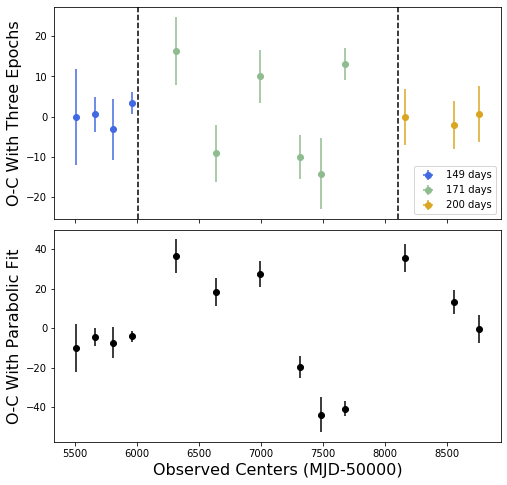

In [197]:
#stack two O-C plots
#put after chi squared final answer -- or move chi s up
fig,ax=plt.subplots(2,1,figsize=(8,8),sharex=True)
plt.subplots_adjust(hspace=.05)
ax[0].errorbar((centers[1],centers[2],centers[3]),err149,linestyle='none',xerr=cen_err[1:4],yerr=cen_err[1:4],marker='o',color='royalblue',label='149 days')
ax[0].errorbar((centers[0]),0,xerr=cen_err[0],yerr=cen_err[0],linestyle='none',marker='o',color='royalblue')

ax[0].errorbar(centers[4:10],err171,linestyle='none',xerr=cen_err[4:10],yerr=cen_err[4:10],marker='o',color='darkseagreen',label='171 days')
ax[0].errorbar(centers[10],0,xerr=cen_err[10],yerr=cen_err[10],linestyle='none',marker='o',color='goldenrod')

ax[0].errorbar(centers[11:],errs200,linestyle='none',xerr=cen_err[11:],yerr=cen_err[11:],marker='o',color='goldenrod',label='200 days')
ax[0].axvline(6006,linestyle='dashed',color='black')
ax[0].axvline(8101,linestyle='dashed',color='black')
ax[0].legend(loc='lower right')


ax[1].errorbar(centers,centers-y_fit,xerr=cen_err,yerr=cen_err,linestyle='none',marker='o',color='black')
ax[1].set_xlabel('Observed Centers (MJD-50000)',fontsize=16)
ax[1].set_ylabel('O-C With Parabolic Fit',fontsize=16)
ax[0].set_ylabel('O-C With Three Epochs',fontsize=16)

png('bothoc')

In [219]:
#try reduced chi squared
rcs = (chi149+chi171+chi200)/(13-5) #13 flares, five parameters?
rcs 

3.5234526690429036

In [220]:
#parabola chi
parabchi = np.sum(((centers-y_fit)/cen_err)**2) #chi squared for changing period
print(parabchi)
print(parabchi/(13-2))

221.29191697725415
20.117446997932195


# make sure chi squared minimized

### summary of chi squared
- verify degrees of freedom and error
- redchi 20 for linearly increasing and 3.5 for three epochs

## new best periods
> If we're just going based on Gaussian centers, we need to re-establish the best periods within each regime, even if the error is a couple of days
- 149,170 or 171 (using 171, but 170 if diff errors taken into acount), 200

# 15. If Most Recent Flare Super Flare

In [221]:
flareinds

[[40, 130],
 [160, 240],
 [241, 258],
 [330, 420],
 [478, 507],
 [510, 536],
 [540, 585],
 [585, 600],
 [600, 630],
 [630, 660],
 [671, 700],
 [711, 738],
 [738, 758]]

Text(0, 0.5, 'OGLE I mag')

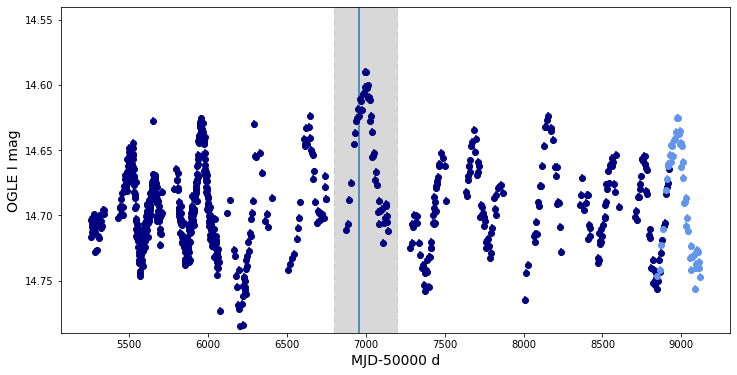

In [223]:
#if shifted down and left
plt.figure(figsize=(12,6))
plt.errorbar(sog4['MJD-50000'],sog4['I detrend 2'],yerr=sog4['I mag err'],linestyle='none',marker='o',color='navy')

plt.axvspan(6800,7200,color='grey',alpha=.3,linestyle='-.')
plt.errorbar(sog4['MJD-50000'][540:585]+1975,sog4['I detrend 2'][540:585]+.035,yerr=sog4['I mag err'][540:585],linestyle='none',marker='o',color='cornflowerblue')
plt.axvline(6956)#where last observation was?
plt.ylim(14.75+.04,14.5+.04)
plt.xlabel('MJD-50000 d',fontsize=14)
plt.ylabel('OGLE I mag',fontsize=14)

<ErrorbarContainer object of 3 artists>

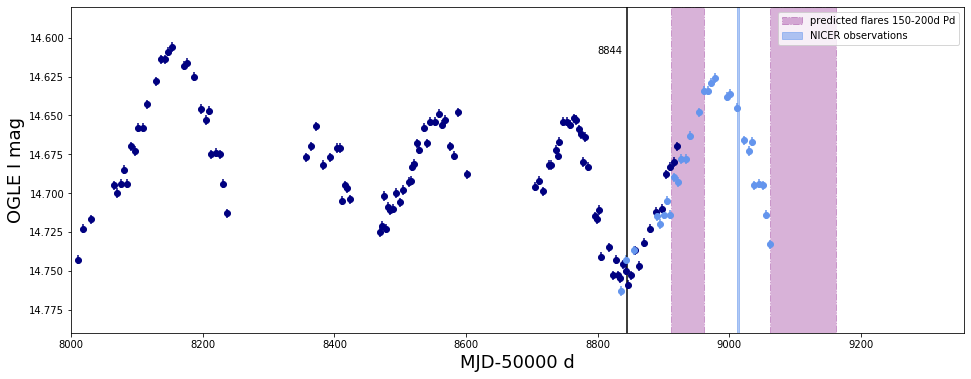

In [224]:
#recent wide flare moved
plt.figure(figsize=(16,6))
plt.errorbar(sog4['MJD-50000'],sog4['I mag'],yerr=sog4['I mag err'],linestyle='none',marker='o',color='navy')
# for c in centers[-2:]:
#     plt.axvline(c,0,1,color='palevioletred',linestyle='dashed')
# plt.axvline(centers[-3],0,1,color='palevioletred',linestyle='dashed',label='flare centers')
plt.axvspan(centers[-1]+150*1,centers[-1]+200*1,color='purple',alpha=.3,linestyle='-.',label='predicted flares 150-200d Pd')
plt.axvspan(centers[-1]+150*2,centers[-1]+200*2,color='purple',alpha=.3,linestyle='-.')

# plt.text(8910,14.6+.04,'2/23-')
# plt.text(8910,14.61+.04,'4/13')
# plt.text(9061,14.6+.04,'7/22-10/30')
#plt.axhline(14.575,.417,.558,color='palevioletred')
#plt.text(8625,14.57,'193 days')
#plt.axvline(9015,0,1,color='lightcoral',label='Nicer Observations')
plt.axvspan(9012, 9015, alpha=0.5, color='cornflowerblue',label='NICER observations')
plt.axvline(8844,color='black')
plt.text(8800,14.57+.04,'8844')
plt.xlim(8000,)
plt.ylim(14.75+.04,14.54+.04)
# plt.errorbar(9031,14.61,color='black',yerr=.04,linestyle='none',marker='o',label='Swift V')
# plt.errorbar(9035,14.63,color='black',yerr=.04,linestyle='none',marker='o')
# plt.errorbar(9039,14.61,color='black',yerr=.041,linestyle='none',marker='o')

# plt.errorbar(9047,14.59,color='black',yerr=.032,linestyle='none',marker='o')

# plt.errorbar(9031,14.68,color='maroon',yerr=.041,linestyle='none',marker='o',label='expected I')
plt.xlabel('MJD-50000 d',fontsize=18)
plt.ylabel('OGLE I mag',fontsize=18)
plt.legend(loc='upper right')
plt.errorbar(sog4['MJD-50000'][671:700]+825,sog4['I mag'][671:700]+.02,yerr=sog4['I mag err'][671:700],linestyle='none',marker='o',color='cornflowerblue')



In [225]:
np.mean([14.61,14.63,14.61,14.59])

14.61

# 15. Remove Middle Wide Flare Before Phase-Fold

Text(0, 0.5, 'OGLE I mag')

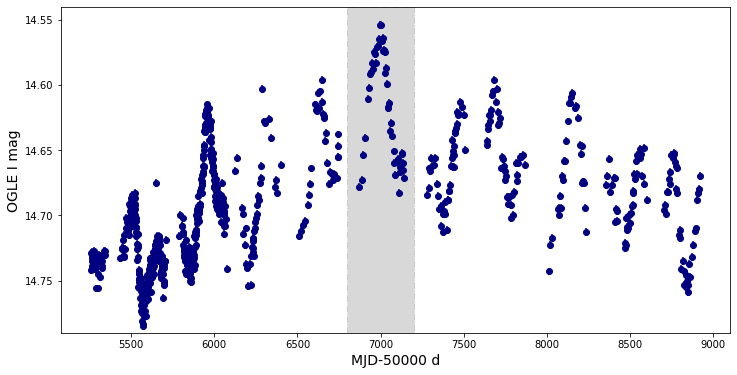

In [226]:
plt.figure(figsize=(12,6))
plt.errorbar(sog4['MJD-50000'],sog4['I mag'],yerr=sog4['I mag err'],linestyle='none',marker='o',color='navy')

plt.axvspan(6800,7200,color='grey',alpha=.3,linestyle='-.')

plt.ylim(14.75+.04,14.5+.04)
plt.xlabel('MJD-50000 d',fontsize=14)
plt.ylabel('OGLE I mag',fontsize=14)
#plt.savefig('fullcurveshaded.png',dpi=200,bbox_inches='tight')

Text(0, 0.5, 'OGLE I mag')

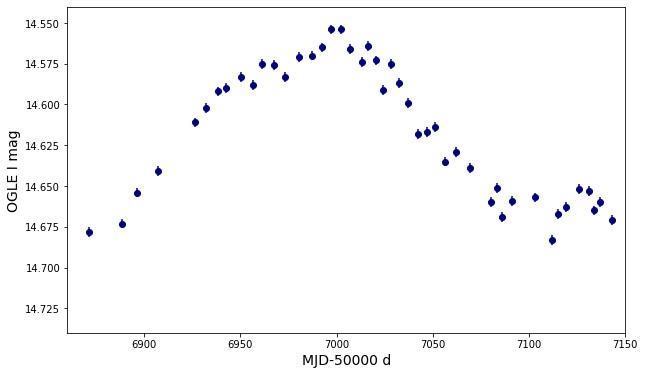

In [227]:
#plot of middle flare, not saved right now
plt.figure(figsize=(10,6))
plt.errorbar(sog4['MJD-50000'],sog4['I mag'],yerr=sog4['I mag err'],linestyle='none',marker='o',color='navy')

plt.xlim(6860,7150)
plt.ylim(14.7+.04,14.5+.04)
plt.xlabel('MJD-50000 d',fontsize=14)
plt.ylabel('OGLE I mag',fontsize=14)

In [232]:
sogf = pd.concat((sog4[:540],sog4[585:])) #filtered sog4
firstpart = phase_t[:540]
thirdpart = phase_t[585:]
phase_f = np.concatenate((firstpart,thirdpart))

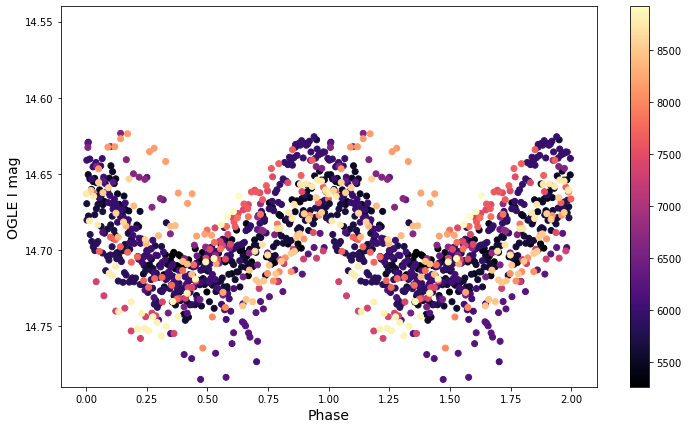

In [233]:
plt.figure(figsize=(12,7))
plt.ylim(14.75+.04,14.54)
plt.scatter(phase_f,sogf['I detrend 2'],c=sogf['MJD-50000'],cmap='magma')
plt.scatter(1+phase_f,sogf['I detrend 2'],c=sogf['MJD-50000'],cmap='magma')
plt.ylabel('OGLE I mag',fontsize=14)
plt.xlabel('Phase',fontsize=14)
plt.colorbar()

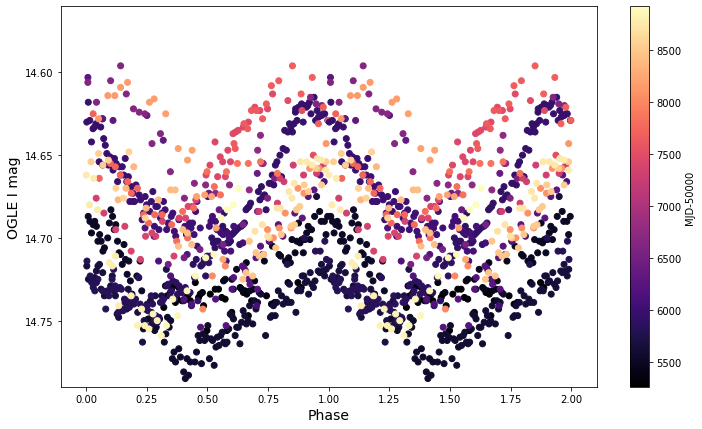

In [234]:
#same but detrended
plt.figure(figsize=(12,7))
plt.ylim(14.75+.04,14.52+.04)
plt.scatter(phase_f,sogf['I mag'],c=sogf['MJD-50000'],cmap='magma')
plt.scatter(1+phase_f,sogf['I mag'],c=sogf['MJD-50000'],cmap='magma')
plt.ylabel('OGLE I mag',fontsize=14)
plt.xlabel('Phase',fontsize=14)
plt.colorbar(label='MJD-50000')

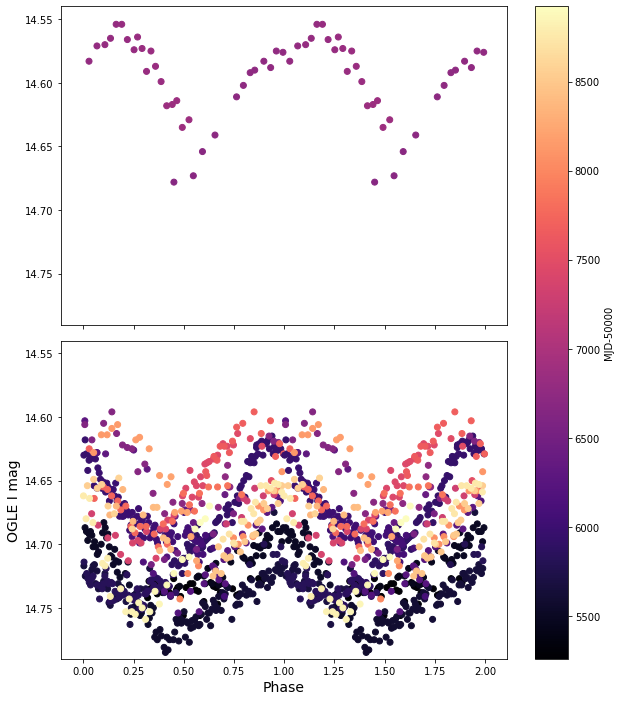

In [235]:
#is this the envisioned two-panel figure?
fig,ax=plt.subplots(2,1,figsize=(10,12),sharey=True,sharex=True)
#midphase = np.roll((sog4['MJD-50000'][612:650]-sog4['MJD-50000'][612])/(sog4['MJD-50000'][650]-sog4['MJD-50000'][612]),18)
#ax[0].scatter(midphase,sog4['I mag'][612:650],color='black')
#ax[0].scatter(1+midphase,sog4['I mag'][612:650],color='black')
#ax[0].scatter(sog4['MJD-50000'][612:650],sog4['I mag'][612:650],color='black')

#plotting fold just separately
im1=ax[0].scatter(phase_t[540:571],sog4['I mag'][540:571],c=sog4['MJD-50000'][540:571],cmap='magma',vmin=5540,vmax=9000)
im1=ax[0].scatter(1+phase_t[540:571],sog4['I mag'][540:571],c=sog4['MJD-50000'][540:571],cmap='magma',vmin=5540,vmax=9000)


ax[1].set_ylim(14.75+.04,14.5+.04)
plt.subplots_adjust(hspace=0.05)
im=ax[1].scatter(phase_f,sogf['I mag'],c=sogf['MJD-50000'],cmap='magma')
ax[1].scatter(1+phase_f,sogf['I mag'],c=sogf['MJD-50000'],cmap='magma')
ax[1].set_ylabel('OGLE I mag',fontsize=14)
ax[1].set_xlabel('Phase',fontsize=14)
fig.colorbar(im,ax=ax,label='MJD-50000')
#png('sepflareor')

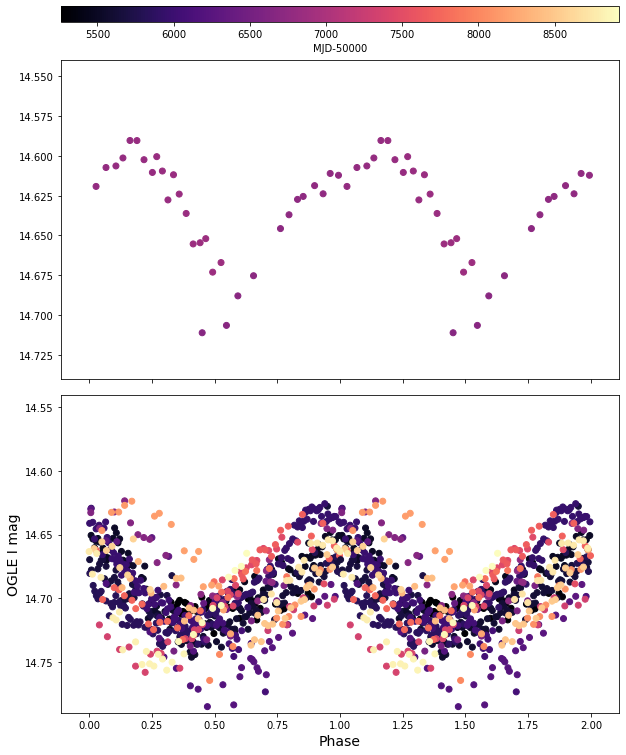

In [236]:
#is this the envisioned two-panel figure?
fig,ax=plt.subplots(2,1,figsize=(10,12),sharex=True)
#midphase = np.roll((sog4['MJD-50000'][612:650]-sog4['MJD-50000'][612])/(sog4['MJD-50000'][650]-sog4['MJD-50000'][612]),18)
#ax[0].scatter(midphase,sog4['I mag'][612:650],color='black')
#ax[0].scatter(1+midphase,sog4['I mag'][612:650],color='black')
#ax[0].scatter(sog4['MJD-50000'][612:650],sog4['I mag'][612:650],color='black')

#plotting fold just separately
im1=ax[0].scatter(phase_t[540:571],sog4['I detrend 2'][540:571],c=sog4['MJD-50000'][540:571],cmap='magma',vmin=5540,vmax=9000)
im1=ax[0].scatter(1+phase_t[540:571],sog4['I detrend 2'][540:571],c=sog4['MJD-50000'][540:571],cmap='magma',vmin=5540,vmax=9000)


ax[1].set_ylim(14.75+.04,14.5+.04)
plt.subplots_adjust(hspace=0.05)
im=ax[1].scatter(phase_f,sogf['I detrend 2'],c=sogf['MJD-50000'],cmap='magma')
ax[1].scatter(1+phase_f,sogf['I detrend 2'],c=sogf['MJD-50000'],cmap='magma')
ax[1].set_ylabel('OGLE I mag',fontsize=14)
ax[1].set_xlabel('Phase',fontsize=14)
ax[0].set_ylim(14.7+.04,14.5+.04)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax[0],
                   width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50%
                   loc='upper right',bbox_to_anchor=(0, .17, 1, 1),
                   bbox_transform=ax[0].transAxes,
                   borderpad=0,
                   )

fig.colorbar(im,cax=axins,label='MJD-50000',orientation='horizontal',pad=.08)
#png('sepflaredet')

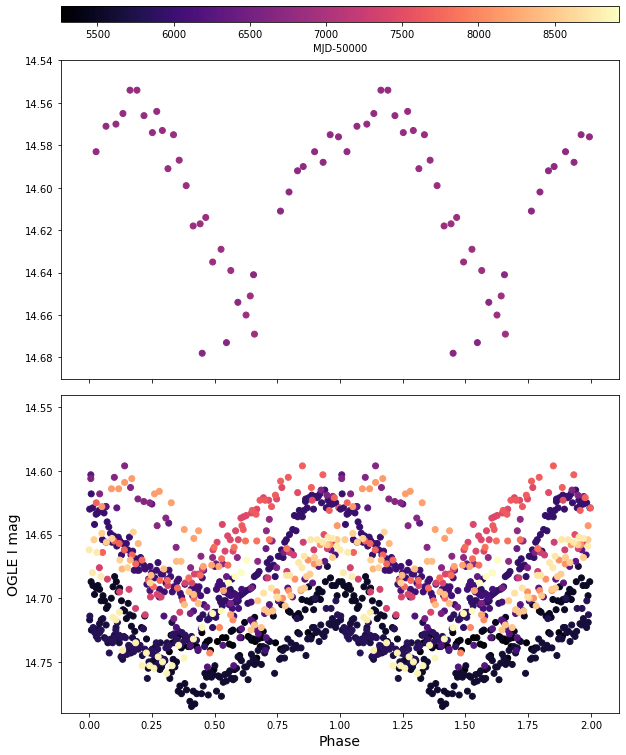

In [237]:
#is this the envisioned two-panel figure?
fig,ax=plt.subplots(2,1,figsize=(10,12),sharex=True)
#midphase = np.roll((sog4['MJD-50000'][612:650]-sog4['MJD-50000'][612])/(sog4['MJD-50000'][650]-sog4['MJD-50000'][612]),18)
#ax[0].scatter(midphase,sog4['I mag'][612:650],color='black')
#ax[0].scatter(1+midphase,sog4['I mag'][612:650],color='black')
#ax[0].scatter(sog4['MJD-50000'][612:650],sog4['I mag'][612:650],color='black')

#plotting fold just separately
im1=ax[0].scatter(phase_t[540:575],sog4['I mag'][540:575],c=sog4['MJD-50000'][540:575],cmap='magma',vmin=5540,vmax=9000)
im1=ax[0].scatter(1+phase_t[540:575],sog4['I mag'][540:575],c=sog4['MJD-50000'][540:575],cmap='magma',vmin=5540,vmax=9000)

ax[0].set_ylim(14.65+.04,14.5+.04)
ax[1].set_ylim(14.75+.04,14.5+.04)
plt.subplots_adjust(hspace=0.05)
im=ax[1].scatter(phase_f,sogf['I mag'],c=sogf['MJD-50000'],cmap='magma')
ax[1].scatter(1+phase_f,sogf['I mag'],c=sogf['MJD-50000'],cmap='magma')
ax[1].set_ylabel('OGLE I mag',fontsize=14)
ax[1].set_xlabel('Phase',fontsize=14)
axins = inset_axes(ax[0],
                   width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50%
                   loc='upper right',bbox_to_anchor=(0, .17, 1, 1),
                   bbox_transform=ax[0].transAxes,
                   borderpad=0,
                   )

fig.colorbar(im,cax=axins,label='MJD-50000',orientation='horizontal',pad=.08)
#png('sepflareor')

# Swift LC

In [267]:
swlc = pd.read_csv('../LXP69.5_Swift/lc/curve.qdp',delimiter='\s',skiprows=10,comment='!',
                   names=['MJD','T_+ve','T_-ve','Rate','Ratepos','Rateneg','OBSID'],engine='python')

In [268]:
swrate = np.array(swlc['Rate'][:15]) #after no are upper limits

In [292]:
swerr = (np.abs(swlc['Rateneg'][:15]),swlc['Ratepos'][:15])

terr = (np.abs(swlc['T_-ve'][:15]),swlc['T_-ve'][:15])


In [269]:
swmjd = np.array(swlc['MJD'][:15])

In [297]:
#upper limits
swum = np.array(swlc['MJD'][15:])
swul = np.array(swlc['Rate'][15:])

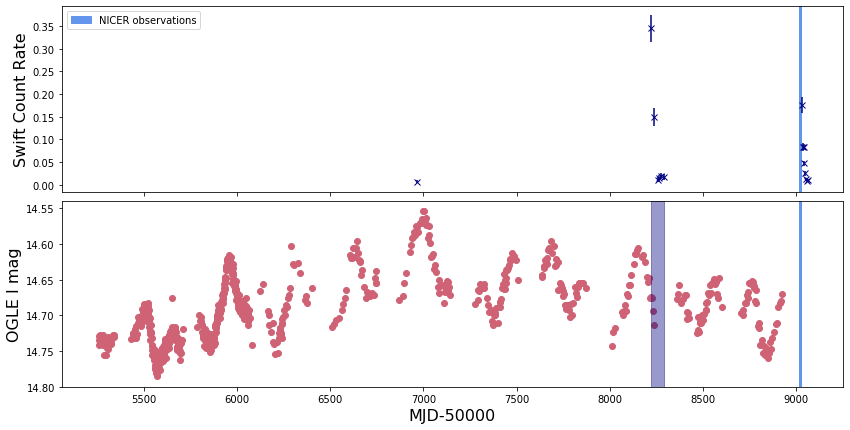

In [310]:
fig,ax=plt.subplots(2,1,figsize=(14,7),sharex=True)
plt.subplots_adjust(hspace=.05)
ax[0].errorbar(swmjd-50000,swrate,xerr=terr,yerr=swerr,marker='x',linestyle='none',color='navy')
#upper limits
#ax[0].errorbar(swum-50000,swul,marker='v',linestyle='none',color='navy')

ax[1].scatter(sog4['MJD-50000'],sog4['I mag'],color=c4)
ax[1].set_ylim(14.8,14.54)
ax[1].set_ylabel('OGLE I mag',fontsize=16)
ax[1].set_xlabel('MJD-50000',fontsize=16)
ax[0].set_ylabel('Swift Count Rate',fontsize=16)

ax[0].axvspan(9012,9025,color='cornflowerblue',label='NICER observations')
ax[1].axvspan(9012,9025,color='cornflowerblue',label='NICER observations')
ax[0].legend(loc='upper left')
ax[1].axvspan(8220,8290,color='navy',alpha=.4)
png('swog')

In [266]:
swmjd

array(['56967.9694894051', '58220.410226103', '58234.2115749653',
       '58255.4869675336', '58262.1871824676', '58276.1977060741',
       '58290.7882160069', '59031.3400623264', '59035.1876386111',
       '59039.0636183796', '59043.2435629977', '59047.1561329398',
       '59051.2167201273', '59055.8181830093', '59059.8996070833'],
      dtype=object)

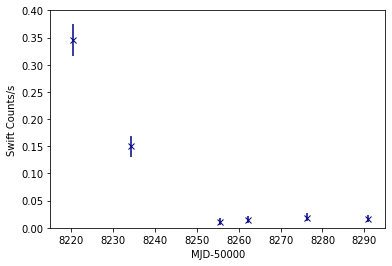

In [317]:
plt.errorbar(swmjd-50000,swrate,xerr=terr,yerr=swerr,marker='x',linestyle='none',color='navy')
plt.xlim(8215,8295)
plt.ylim(0,.4)
plt.ylabel('Swift Counts/s')
plt.xlabel('MJD-50000')
#plt.yscale('log')
png('sw1')